<a href="https://colab.research.google.com/github/shreyab375/Infrabel-Data-Analysis/blob/main/Infrabel_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install contextily

In [2]:
#import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Set the aesthetic style of the plots
sns.set(style="whitegrid")
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from shapely.geometry import LineString, Point
import ast
import geopandas as gpd
import json
import folium
import contextily as ctx
import plotly.express as px
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

In [3]:
#Read the data
df_reg = pd.read_csv("/content/drive/MyDrive/Regular data.csv", sep=";") # regular train schedule
df_inc = pd.read_csv("/content/drive/MyDrive/Incidents.csv", sep=";") # Incidents data
df_et = pd.read_csv("/content/drive/MyDrive/ETCS.csv",sep=";") # ETCS data; Sometime just explicitly giving the "sep" parameter helps. Seems to be a parser issue.

In [4]:
#Sanity Checks
df_reg.head()

Date of departure  Train number Relation Railway operator Departure line  \
0        2024-10-01          3784   L B2-2        SNCB/NMBS             36   
1        2024-10-01          3784   L B2-2        SNCB/NMBS             27   
2        2024-10-01          3784   L B2-2        SNCB/NMBS            0/6   
3        2024-10-01          3784   L B2-2        SNCB/NMBS            0/6   
4        2024-10-01          3784   L B2-2        SNCB/NMBS             96   

  Actual arrival time Actual departure time Planned arrival time  \
0            13:40:48              13:42:10             13:40:10   
1            13:45:54              13:46:51             13:45:00   
2            13:51:30              13:52:59             13:50:00   
3            13:57:02              13:58:27             13:55:00   
4            14:15:33              14:16:32             14:13:10   

  Planned departure time  Delay at arrival  Delay at departure  \
0               13:41:00              38.0                70.0   
1               13:46:00              54.0                51.0   
2               13:52:00              90.0                59.0   
3               13:56:00             122.0               147.0   
4               14:14:00             143.0               152.0   

                  Relation direction    Stopping place Arrival line  \
0  L B2-2: LEUVEN -> BRAINE-LE-COMTE        HAREN-ZUID           36   
1  L B2-2: LEUVEN -> BRAINE-LE-COMTE        SCHAARBEEK           36   
2  L B2-2: LEUVEN -> BRAINE-LE-COMTE     BRUSSEL-NOORD           27   
3  L B2-2: LEUVEN -> BRAINE-LE-COMTE  BRUSSEL-CENTRAAL          0/6   
4  L B2-2: LEUVEN -> BRAINE-LE-COMTE               LOT           96   

  Planned arrival date Planned departure date Actual arrival date  \
0           2024-10-01             2024-10-01          2024-10-01   
1           2024-10-01             2024-10-01          2024-10-01   
2           2024-10-01             2024-10-01          2024-10-01   
3           2024-10-01             2024-10-01          2024-10-01   
4           2024-10-01             2024-10-01          2024-10-01   

  Actual departure date  
0            2024-10-01  
1            2024-10-01  
2            2024-10-01  
3            2024-10-01  
4            2024-10-01

In [5]:
df_inc.head()

Month Incident date Line          Place         Place.1         Place.2  \
0  2019-01    2019-01-15  50A    Y.MEULEWIJK     Y.MEULEWIJK     Y.MEULEWIJK   
1  2019-01    2019-01-15  0/2  BRUSSEL-NOORD  BRUXELLES-NORD  BRUSSELS-NORTH   
2  2019-01    2019-01-17  50A        BEERNEM         BEERNEM         BEERNEM   
3  2019-01    2019-01-18  161    GROENENDAAL     GROENENDAAL     GROENENDAAL   
4  2019-02    2019-02-01   27      VILVOORDE       VILVOORDE       VILVOORDE   

                 Incident description  \
0                 Schade bovenleiding   
1                         Spoorlopers   
2                     Persoonsongeval   
3  Uitzonderlijke weersomstandigheden   
4                         Spoorlopers   

                       Incident description.1          Incident description.2  \
0                            Avarie caténaire                 Damage catenary   
1                    Intrusion dans les voies       Intrusion into the tracks   
2                        Heurt d'une personne         Collision with a person   
3  Conditions météorologiques exceptionnelles  Exceptional weather conditions   
4                    Intrusion dans les voies       Intrusion into the tracks   

   Minutes of delay  Number of cancelled trains  
0              1776                          23  
1              2799                          22  
2              1214                          35  
3              4388                          89  
4              1411                          16

In [6]:
df_et.head()

ID  ETCS level Line  Track  \
0   6  ETCS L1 FS   13      1   
1   8  ETCS L1 FS   13      1   
2   9  ETCS L1 FS   15      2   
3  13  ETCS L1 FS   15      2   
4  16  ETCS L1 FS   15      1   

                                            GeoShape  \
0  {"coordinates": [[[4.475402362936699, 51.13648...   
1  {"coordinates": [[[4.491114722634299, 51.12926...   
2  {"coordinates": [[[4.465347432408299, 51.17941...   
3  {"coordinates": [[[4.541061713312562, 51.13946...   
4  {"coordinates": [[[4.570739057896543, 51.13826...   

                             geo_point_2d  
0   51.130787300206606, 4.482197206085314  
1    51.13157005435598, 4.515333773598648  
2    51.17578363963682, 4.473576126486522  
3  51.136460885742835, 4.5557358313932195  
4     51.1409614382676, 4.576937041197707

# Preprocessing and Cleaning the data
#### Preprocessing the table with Regular timing data


In [7]:
#converting the data formats for easy manipulations
df_reg['Date of departure'] = pd.to_datetime(df_reg['Date of departure'])
df_reg['Planned arrival date'] = pd.to_datetime(df_reg['Planned arrival date'])
df_reg['Planned departure date'] = pd.to_datetime(df_reg['Planned departure date'])
df_reg['Actual arrival date'] = pd.to_datetime(df_reg['Actual arrival date'])
df_reg['Actual departure date'] = pd.to_datetime(df_reg['Actual departure date'])
df_reg['Departure line'] = df_reg['Departure line'].astype(str)  # Ensure the line numbers are strings

In [8]:
#converting seconds to minutes for clarity
df_reg['Delay at arrival'] = df_reg['Delay at arrival'] / 60
df_reg['Delay at departure'] = df_reg['Delay at departure'] / 60

In [9]:
df_reg.shape

(74413, 18)

In [10]:
#Finding the min and max dates to make sure it's only one day data
print(df_reg['Date of departure'].max())
print(df_reg['Date of departure'].min())

2024-10-01 00:00:00
2024-10-01 00:00:00


In [11]:
df_reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74413 entries, 0 to 74412
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date of departure       74413 non-null  datetime64[ns]
 1   Train number            74413 non-null  int64         
 2   Relation                74413 non-null  object        
 3   Railway operator        74413 non-null  object        
 4   Departure line          74413 non-null  object        
 5   Actual arrival time     70822 non-null  object        
 6   Actual departure time   70827 non-null  object        
 7   Planned arrival time    70822 non-null  object        
 8   Planned departure time  70827 non-null  object        
 9   Delay at arrival        70822 non-null  float64       
 10  Delay at departure      70827 non-null  float64       
 11  Relation direction      70130 non-null  object        
 12  Stopping place          74413 non-null  object

In [12]:
df_reg.describe()

Date of departure  Train number  Delay at arrival  \
count                74413  74413.000000      70822.000000   
mean   2024-10-01 00:00:00   3625.103342          2.099762   
min    2024-10-01 00:00:00     10.000000        -18.083333   
25%    2024-10-01 00:00:00   2041.000000          0.066667   
50%    2024-10-01 00:00:00   3211.000000          0.950000   
75%    2024-10-01 00:00:00   4555.000000          2.733333   
max    2024-10-01 00:00:00  19975.000000        134.300000   
std                    NaN   2556.129221          4.429249   

       Delay at departure           Planned arrival date  \
count        70827.000000                          70822   
mean             2.126113  2024-10-01 00:06:02.328089856   
min            -18.083333            2024-10-01 00:00:00   
25%              0.200000            2024-10-01 00:00:00   
50%              0.916667            2024-10-01 00:00:00   
75%              2.666667            2024-10-01 00:00:00   
max            133.866667            2024-10-02 00:00:00   
std              4.293813                            NaN   

              Planned departure date            Actual arrival date  \
count                          70827                          70822   
mean   2024-10-01 00:05:28.146045952  2024-10-01 00:06:37.706926848   
min              2024-10-01 00:00:00            2024-10-01 00:00:00   
25%              2024-10-01 00:00:00            2024-10-01 00:00:00   
50%              2024-10-01 00:00:00            2024-10-01 00:00:00   
75%              2024-10-01 00:00:00            2024-10-01 00:00:00   
max              2024-10-02 00:00:00            2024-10-02 00:00:00   
std                              NaN                            NaN   

               Actual departure date  
count                          70827  
mean   2024-10-01 00:06:01.082638080  
min              2024-10-01 00:00:00  
25%              2024-10-01 00:00:00  
50%              2024-10-01 00:00:00  
75%              2024-10-01 00:00:00  
max              2024-10-02 00:00:00  
std                              NaN

In [13]:
#Checking the null value columns
missing_values = df_reg.isnull().sum()

#Filter columns with missing values
missing_columns = missing_values[missing_values > 0]

# Display columns with missing values
print("Columns with missing values:")
print(missing_columns)

Columns with missing values:
Actual arrival time       3591
Actual departure time     3586
Planned arrival time      3591
Planned departure time    3586
Delay at arrival          3591
Delay at departure        3586
Relation direction        4283
Arrival line              3591
Planned arrival date      3591
Planned departure date    3586
Actual arrival date       3591
Actual departure date     3586
dtype: int64


In [14]:
#showing the null value columns
# Step 1: Create a boolean mask for missing values
missing_mask = df_reg.isnull().any(axis=1)

# Step 2: Filter the DataFrame to show rows with at least one null value
rows_with_nulls = df_reg[missing_mask]

# Display the rows with null values
print("Rows with null values:")
print(rows_with_nulls)

Rows with null values:
      Date of departure  Train number Relation Railway operator  \
8            2024-10-01          3784   L B2-2        SNCB/NMBS   
13           2024-10-01          4237    IC 30        SNCB/NMBS   
21           2024-10-01          4234    IC 30        SNCB/NMBS   
38           2024-10-01          4216    IC 30        SNCB/NMBS   
43           2024-10-01          4213    IC 30        SNCB/NMBS   
...                 ...           ...      ...              ...   
74405        2024-10-01          8283        P        SNCB/NMBS   
74406        2024-10-01          8283        P        SNCB/NMBS   
74407        2024-10-01          8283        P        SNCB/NMBS   
74408        2024-10-01          8283        P        SNCB/NMBS   
74409        2024-10-01           826    IC 32        SNCB/NMBS   

      Departure line Actual arrival time Actual departure time  \
8                nan            14:41:53                   NaN   
13              59/1                 NaN

##### It turns out there are around 10,779 columns with either of the columns missing which is around 14% of the total data. We can do the data imputation based on the average time based on the same route but for simplicity I am dropping it.

In [15]:
df_reg.dropna(inplace=True)

In [16]:
df_reg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 63634 entries, 0 to 74412
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date of departure       63634 non-null  datetime64[ns]
 1   Train number            63634 non-null  int64         
 2   Relation                63634 non-null  object        
 3   Railway operator        63634 non-null  object        
 4   Departure line          63634 non-null  object        
 5   Actual arrival time     63634 non-null  object        
 6   Actual departure time   63634 non-null  object        
 7   Planned arrival time    63634 non-null  object        
 8   Planned departure time  63634 non-null  object        
 9   Delay at arrival        63634 non-null  float64       
 10  Delay at departure      63634 non-null  float64       
 11  Relation direction      63634 non-null  object        
 12  Stopping place          63634 non-null  object     

### Preprocessing the table with Incidents data

In [17]:
#Preprocessing for the Incident data
df_inc.shape

(738, 11)

In [18]:

df_inc['Incident date'] = pd.to_datetime(df_inc['Incident date']) #Ensuring dates are in same format
df_inc['Line'] = df_inc['Line'].astype(str)  # Ensure the line numbers are strings

In [19]:
df_inc.describe()

Incident date  Minutes of delay  \
count                            738        738.000000   
mean   2021-12-20 09:33:39.512195072       2148.979675   
min              2019-01-03 00:00:00         17.000000   
25%              2020-07-02 18:00:00       1167.000000   
50%              2022-03-30 00:00:00       1452.000000   
75%              2023-04-19 00:00:00       2106.750000   
max              2024-08-31 00:00:00      44735.000000   
std                              NaN       2875.372034   

       Number of cancelled trains  
count                  738.000000  
mean                    52.521680  
min                      0.000000  
25%                     17.000000  
50%                     31.000000  
75%                     57.000000  
max                   1492.000000  
std                    100.720768

In [20]:
df_inc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 738 entries, 0 to 737
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Month                       738 non-null    object        
 1   Incident date               738 non-null    datetime64[ns]
 2   Line                        738 non-null    object        
 3   Place                       738 non-null    object        
 4   Place.1                     738 non-null    object        
 5   Place.2                     738 non-null    object        
 6   Incident description        738 non-null    object        
 7   Incident description.1      738 non-null    object        
 8   Incident description.2      738 non-null    object        
 9   Minutes of delay            738 non-null    int64         
 10  Number of cancelled trains  738 non-null    int64         
dtypes: datetime64[ns](1), int64(2), object(8)
memory usage: 63

###### No Null values in this *table*

### Preprocessing the table with ETCS data

In [21]:
#Preporocessing of the ETCS table
df_et.shape

(873, 6)

In [22]:
df_et.describe()

ID       Track
count  873.000000  873.000000
mean   453.896907    1.569301
std    261.513982    0.600131
min      1.000000    1.000000
25%    231.000000    1.000000
50%    454.000000    2.000000
75%    675.000000    2.000000
max    907.000000    3.000000

In [23]:
df_et.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 873 entries, 0 to 872
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ID            873 non-null    int64 
 1   ETCS level    873 non-null    object
 2   Line          873 non-null    object
 3   Track         873 non-null    int64 
 4   GeoShape      873 non-null    object
 5   geo_point_2d  873 non-null    object
dtypes: int64(2), object(4)
memory usage: 41.0+ KB


##### No Null values in this table

# **Exploratory Data Analysis**

In [24]:
#Let'a explore the df_reg first
df_reg.head()


Date of departure  Train number Relation Railway operator Departure line  \
0        2024-10-01          3784   L B2-2        SNCB/NMBS             36   
1        2024-10-01          3784   L B2-2        SNCB/NMBS             27   
2        2024-10-01          3784   L B2-2        SNCB/NMBS            0/6   
3        2024-10-01          3784   L B2-2        SNCB/NMBS            0/6   
4        2024-10-01          3784   L B2-2        SNCB/NMBS             96   

  Actual arrival time Actual departure time Planned arrival time  \
0            13:40:48              13:42:10             13:40:10   
1            13:45:54              13:46:51             13:45:00   
2            13:51:30              13:52:59             13:50:00   
3            13:57:02              13:58:27             13:55:00   
4            14:15:33              14:16:32             14:13:10   

  Planned departure time  Delay at arrival  Delay at departure  \
0               13:41:00          0.633333            1.166667   
1               13:46:00          0.900000            0.850000   
2               13:52:00          1.500000            0.983333   
3               13:56:00          2.033333            2.450000   
4               14:14:00          2.383333            2.533333   

                  Relation direction    Stopping place Arrival line  \
0  L B2-2: LEUVEN -> BRAINE-LE-COMTE        HAREN-ZUID           36   
1  L B2-2: LEUVEN -> BRAINE-LE-COMTE        SCHAARBEEK           36   
2  L B2-2: LEUVEN -> BRAINE-LE-COMTE     BRUSSEL-NOORD           27   
3  L B2-2: LEUVEN -> BRAINE-LE-COMTE  BRUSSEL-CENTRAAL          0/6   
4  L B2-2: LEUVEN -> BRAINE-LE-COMTE               LOT           96   

  Planned arrival date Planned departure date Actual arrival date  \
0           2024-10-01             2024-10-01          2024-10-01   
1           2024-10-01             2024-10-01          2024-10-01   
2           2024-10-01             2024-10-01          2024-10-01   
3           2024-10-01             2024-10-01          2024-10-01   
4           2024-10-01             2024-10-01          2024-10-01   

  Actual departure date  
0            2024-10-01  
1            2024-10-01  
2            2024-10-01  
3            2024-10-01  
4            2024-10-01

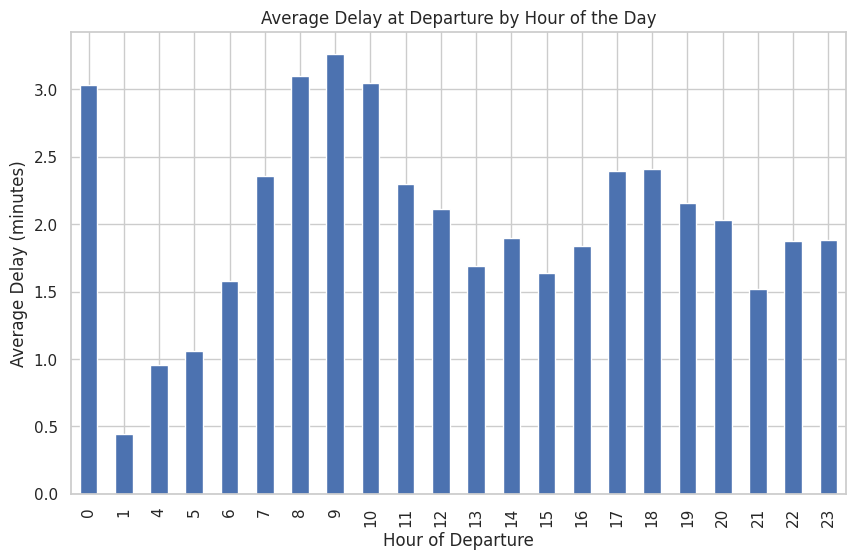

Correlation between hour of departure and delay: -0.04


In [25]:
# Is there any relation between hours of departure and delays?
#_____________________________________________________________________________________-
# Convert 'Actual departure time' to datetime format
df_reg['Actual departure time'] = pd.to_datetime(df_reg['Actual departure time'], format='%H:%M:%S')

# Extract the hour from the 'Actual departure time'
df_reg['Departure hour'] = df_reg['Actual departure time'].dt.hour

# # Plot the delay at departure based on departure hour
mean_delay_per_hour = df_reg.groupby('Departure hour')['Delay at departure'].mean()

# Plot the mean delay per hour
plt.figure(figsize=(10, 6))
mean_delay_per_hour.plot(kind='bar')
plt.title('Average Delay at Departure by Hour of the Day')
plt.xlabel('Hour of Departure')
plt.ylabel('Average Delay (minutes)')
plt.xticks(rotation=90)
plt.show()

# Check correlation between hour of departure and delay
correlation = df_reg['Departure hour'].corr(df_reg['Delay at departure'])
print(f'Correlation between hour of departure and delay: {correlation:.2f}')

In [26]:
#1. Is there any relation between the departure line and delays?
#--------------------------------------------------------------------------------------------------

#  Group by Departure Line and Calculate Average Delays
avg_delays = df_reg.groupby('Departure line')[['Delay at arrival', 'Delay at departure']].mean().reset_index()

#  Create the Interactive Plot
fig = px.bar(
    avg_delays,
    x='Departure line',
    y=['Delay at arrival', 'Delay at departure'],
    barmode='group',
    title='Average Delays by Departure Line',
    labels={'value': 'Average Delay (in minutes)', 'Departure line': 'Departure Line'},
)

# Show the plot
fig.show()



*   If departure delays and arrival delays are equal, it suggests that the trains are maintaining a consistent time difference from their scheduled timetable. This might indicate a systematic issue affecting the entire journey of the train.
*   Departure delays can ripple through the train network, affecting subsequent services. If a train leaves late, it may cause delays for connecting trains and services, leading to broader network disruptions.



In [27]:
#2. Is the stopping place with highest delays corresponds to the "Line" with highest delays?
#-----------------------------------------------------------------------------------------------
avg_delays = df_reg.groupby('Stopping place').agg(
    avg_delay_departure=('Delay at departure', 'mean'),
    avg_delay_arrival=('Delay at arrival', 'mean')
).reset_index()

# Identify the stopping place with the highest average departure delay
highest_delay = avg_delays.loc[avg_delays['avg_delay_departure'].idxmax()]

#  Print the stopping place with the highest delay
print("Stopping place with the highest departure delay:")
print(highest_delay)

#  Visualize the average delays using Plotly
fig = px.bar(
    avg_delays,
    x='Stopping place',
    y=['avg_delay_departure', 'avg_delay_arrival'],
    title='Average Departure and Arrival Delays by Stopping Place',
    labels={'value': 'Average Delay (minutes)', 'Stopping place': 'Stopping Place'},
    barmode='group'
)

# Show the plot
fig.show()

Stopping place with the highest departure delay:
Stopping place         HERGENRATH
avg_delay_departure     15.406818
avg_delay_arrival       15.329545
Name: 243, dtype: object


In [28]:
#Getting the same figure for top 10 places
#Group by stopping place and calculate average delays
avg_delays = df_reg.groupby('Stopping place').agg(
    avg_delay_departure=('Delay at departure', 'mean'),
    avg_delay_arrival=('Delay at arrival', 'mean')
).reset_index()

#  Sort by average departure delay and select the top 10
top_delays = avg_delays.sort_values(by='avg_delay_departure', ascending=False).head(10)

# : Print the top 10 stopping places with the highest departure delays
print("Top 10 Stopping Places with Highest Average Departure Delays:")
print(top_delays)

#  Visualize the average delays using Plotly
fig = px.bar(
    top_delays,
    x='Stopping place',
    y=['avg_delay_departure', 'avg_delay_arrival'],
    title='Top 10 Stopping Places with Highest Average Departure and Arrival Delays',
    labels={'value': 'Average Delay (minutes)', 'Stopping place': 'Stopping Place'},
    barmode='group'
)

# Show the plot
fig.show()

Top 10 Stopping Places with Highest Average Departure Delays:
    Stopping place  avg_delay_departure  avg_delay_arrival
243     HERGENRATH            15.406818          15.329545
205          GOUVY             8.388172           7.546774
537       VIELSALM             7.832381           7.608571
116            COO             7.830476           8.330000
525    TROIS-PONTS             7.279524           7.400952
34        AYWAILLE             7.188571           7.712381
502       STOUMONT             6.954762           6.954762
432       OVERPELT             6.538725           6.427451
342         LOMMEL             6.451471           6.696569
415  NOORDERKEMPEN             6.044872           5.614103


In [29]:
#Let's Visualize in the map
# Coordinates for the top 10 stopping places (approximate values)
places_coordinates = {
    'HERGENRATH': [50.7115, 6.0116],
    'GOUVY': [50.1899, 5.9335],
    'VIELSALM': [50.2791, 5.9241],
    'COO': [50.3943, 5.8998],
    'TROIS-PONTS': [50.3761, 5.8663],
    'AYWAILLE': [50.4751, 5.6761],
    'STOUMONT': [50.4454, 5.8261],
    'OVERPELT': [51.2142, 5.4486],
    'LOMMEL': [51.2300, 5.3139],
    'NOORDERKEMPEN': [51.3465, 4.7126]
}

# Top 10 stopping places with average departure delays
top_10_places = [
    ('HERGENRATH', 15.406818),
    ('GOUVY', 8.388172),
    ('VIELSALM', 7.832381),
    ('COO', 7.830476),
    ('TROIS-PONTS', 7.279524),
    ('AYWAILLE', 7.188571),
    ('STOUMONT', 6.954762),
    ('OVERPELT', 6.538725),
    ('LOMMEL', 6.451471),
    ('NOORDERKEMPEN', 6.044872)
]

# Create a Folium map centered around Belgium
belgium_map = folium.Map(location=[50.8503, 4.3517], zoom_start=8)

# Add circles for each place with delays
for place, delay in top_10_places:
    folium.CircleMarker(
        location=places_coordinates[place],
        radius=delay * 1.5,  # Scale radius by delay
        popup=f'{place}: {delay:.2f} minutes delay',
        color='red',
        fill=True,
        fill_color='red'
    ).add_to(belgium_map)

# Display the map
belgium_map.save("top_10_delays_belgium.html")

In [30]:
#3. Is the top 10 lines with highest delays corresponds to top 10 places with highest delays?
#----------------------------------------------------------------------------------------------------

#Group by Departure Line and calculate average delays
avg_line_delays = df_reg.groupby('Departure line').agg(
    avg_delay_departure=('Delay at departure', 'mean'),
    avg_delay_arrival=('Delay at arrival', 'mean'),
    corresponding_stopping_places=('Stopping place', lambda x: ', '.join(set(x)))  # List unique stopping places
).reset_index()

# Step 4: Sort by average departure delay and select the top 10
top_lines = avg_line_delays.sort_values(by='avg_delay_departure', ascending=False).head(10)

# Step 5: Print the top 10 departure lines with the highest average delays
print("Top 10 Departure Lines with Highest Average Departure Delays:")
print(top_lines[['Departure line', 'avg_delay_departure', 'corresponding_stopping_places']])

# Step 6: Visualize the average delays using Plotly
fig = px.bar(
    top_lines,
    x='Departure line',
    y='avg_delay_departure',
    title='Top 10 Departure Lines with Highest Average Departure Delays',
    labels={'avg_delay_departure': 'Average Delay (minutes)', 'Departure line': 'Departure Line'},
)

# Show the plot
fig.show()

Top 10 Departure Lines with Highest Average Departure Delays:
   Departure line  avg_delay_departure  \
79          50A/3            30.450000   
59              3            25.836667   
26         130L/2             9.658333   
73             42             7.356801   
45              2             6.951823   
44             19             6.100895   
71              4             6.044872   
6               1             5.674051   
63          35L/3             5.516667   
50            25N             4.898718   

                        corresponding_stopping_places  
79                                        DENDERLEEUW  
59                                             CHENEE  
26                                           CHATELET  
73  TROIS-PONTS, GOUVY, RIVAGE, AYWAILLE, STOUMONT...  
45                                        LEUVEN, ANS  
44  OVERPELT, NEERPELT, BALEN-WERKPLAATSEN, LOMMEL...  
71                                      NOORDERKEMPEN  
6                          

In [31]:
#Let's plot the lines along with ECTS levels
df_et["ETCS level"].unique() #Finding out the unique ECTS levels to color code

array(['ETCS L1 FS', 'ETCS L1 LS', 'ETCS L2 FS', 'ETCS 1+2', 'TVM-430'],
      dtype=object)

In [32]:
top_lines

Departure line  avg_delay_departure  avg_delay_arrival  \
79          50A/3            30.450000          29.266667   
59              3            25.836667          25.836667   
26         130L/2             9.658333           4.925000   
73             42             7.356801           7.372272   
45              2             6.951823           7.068490   
44             19             6.100895           5.747204   
71              4             6.044872           5.614103   
6               1             5.674051           5.674051   
63          35L/3             5.516667           5.516667   
50            25N             4.898718           4.511859   

                        corresponding_stopping_places  
79                                        DENDERLEEUW  
59                                             CHENEE  
26                                           CHATELET  
73  TROIS-PONTS, GOUVY, RIVAGE, AYWAILLE, STOUMONT...  
45                                        LEUVEN, ANS  
44  OVERPELT, NEERPELT, BALEN-WERKPLAATSEN, LOMMEL...  
71                                      NOORDERKEMPEN  
6                                               HALLE  
63                                    LEUVEN-BUNDEL M  
50                                           MECHELEN

In [33]:
#Let's visualize in the map

# Color mapping based on ETCS levels
color_map = {
    "ETCS L1 FS": "blue",
    "ETCS L2 FS": "orange",
    'ETCS L1 LS': "yellow",
    'ETCS 1+2': "green",
    'TVM-430' :"cyan"

}

# Create a Folium map centered around Belgium
belgium_map = folium.Map(location=[50.8503, 4.3517], zoom_start=8)

 # Coordinates for the top 10 stopping places (approximate values)
places_coordinates = {
    'HERGENRATH': [50.7115, 6.0116],
    'GOUVY': [50.1899, 5.9335],
    'VIELSALM': [50.2791, 5.9241],
    'COO': [50.3943, 5.8998],
    'TROIS-PONTS': [50.3761, 5.8663],
    'AYWAILLE': [50.4751, 5.6761],
    'STOUMONT': [50.4454, 5.8261],
    'OVERPELT': [51.2142, 5.4486],
    'LOMMEL': [51.2300, 5.3139],
    'NOORDERKEMPEN': [51.3465, 4.7126]
}

  # Top 10 stopping places with average departure delays
top_10_places = [
    ('HERGENRATH', 15.406818),
    ('GOUVY', 8.388172),
    ('VIELSALM', 7.832381),
    ('COO', 7.830476),
    ('TROIS-PONTS', 7.279524),
    ('AYWAILLE', 7.188571),
    ('STOUMONT', 6.954762),
    ('OVERPELT', 6.538725),
    ('LOMMEL', 6.451471),
    ('NOORDERKEMPEN', 6.044872)
]
#Top lines with delays
top_10_lines = top_lines["Departure line"].tolist()
    # Add circles for each place with delays
for place, delay in top_10_places:
    folium.CircleMarker(
        location=places_coordinates[place],
        radius=delay *3,  # Scale radius by delay
        popup=f'{place}: {delay:.2f} minutes delay',
        color='red',
        fill=True,
        fill_color='red'
    ).add_to(belgium_map)

# Plot lines on the map
for index, entry in df_et.iterrows():
    # Extract coordinates from GeoShape
    coordinates = json.loads(entry["GeoShape"])["coordinates"][0]

    # Create a list of points for the polyline
    points = [(lat, lon) for lon, lat in coordinates]

    # Get the ETCS level and color
    etcs_level = entry["ETCS level"]
    color = color_map.get(etcs_level, "gray")  # Default to gray if not found

    # Create a polyline for the line
    folium.PolyLine(
        locations=points,
        color=color,
        weight=5,
        opacity=0.7,
        popup=f'Line: {entry["Line"]}, Track: {entry["Track"]}, ID: {entry["ID"]}'
    ).add_to(belgium_map)

   # Check if the line is in the top lines
    if entry["Line"] in top_10_lines:
        # Calculate midpoint of the coordinates
        mid_index = len(points) // 2
        midpoint = points[mid_index]

        # Add a marker at the midpoint
        folium.Marker(
            location=midpoint,
            popup=f'Top Line: {entry["Line"]}',
            icon=folium.Icon(color='red')
        ).add_to(belgium_map)



# Save the map to an HTML file
belgium_map.save("belgium_etcs_map.html")

**Inference**

The correlation between stopping places and delays suggests that operational efficiency, passenger demand, and service planning must be balanced. It opens opportunities for enhancing the transit system through targeted interventions, data-driven decision-making, and strategic planning to improve overall service reliability and passenger satisfaction. Further analysis, such as exploring the cause of delays, train scheduling, and capacity management, could provide deeper insights for optimizing the network.

In [34]:
#4. Has the ETCS deployments improved punctuality?
#--------------------------------------------------------------
#Getting the average delay timing of each track from df_reg
df_avg_delay = df_reg.groupby('Departure line').agg({
    'Delay at departure': 'mean',
    'Delay at arrival': 'mean'
}).reset_index()

# Rename columns for clarity
df_avg_delay.columns = ['Departure line', 'Avg Delay at Departure', 'Avg Delay at Arrival']
#df_avg_delay
#unique_departure_lines = df_avg_delay['Departure line'].unique()
#print(unique_departure_lines)

#Getting the Deployment of ECTS status on each line from df_et
df_etcs = df_et.groupby('Line').agg({
    'ETCS level': lambda x: ', '.join(x.unique())  # Returns all unique ETCS levels as a comma-separated string
}).reset_index()

#df_etcs.head()
#unique_departure_lines = df_etcs['Line'].unique()
#print(unique_departure_lines)

#it seems like 01, 02, and 03 in etcs table is same as 0/1, 0/2,0/3 in reg table so changing that
df_etcs['Line'] = df_etcs['Line'].replace({
    '01': '0/1',
    '02': '0/2',
    '03': '0/3'
})

In [35]:
#Merging the two dataset on departure line to see if ECTS has been applied or not
df_delay_etcs = pd.merge(df_avg_delay, df_etcs, left_on =["Departure line"], right_on =["Line"], how="left")
#df_delay_etcs.head()

#Filling the lines with No ETCS as "No ETCS"
df_delay_etcs["ETCS level"] = df_delay_etcs["ETCS level"].fillna("No ETCS")
df_delay_etcs.head()

Departure line  Avg Delay at Departure  Avg Delay at Arrival Line  \
0            0/1                2.936942              2.612132  0/1   
1            0/2                3.089934              2.954107  0/2   
2            0/3                2.323640              2.110169  0/3   
3            0/4                2.599294              2.395766  NaN   
4            0/5                1.582209              1.380410  NaN   

   ETCS level  
0  ETCS L1 FS  
1  ETCS L1 FS  
2  ETCS L1 FS  
3     No ETCS  
4     No ETCS

In [36]:
df_delay_etcs.head()

Departure line  Avg Delay at Departure  Avg Delay at Arrival Line  \
0            0/1                2.936942              2.612132  0/1   
1            0/2                3.089934              2.954107  0/2   
2            0/3                2.323640              2.110169  0/3   
3            0/4                2.599294              2.395766  NaN   
4            0/5                1.582209              1.380410  NaN   

   ETCS level  
0  ETCS L1 FS  
1  ETCS L1 FS  
2  ETCS L1 FS  
3     No ETCS  
4     No ETCS

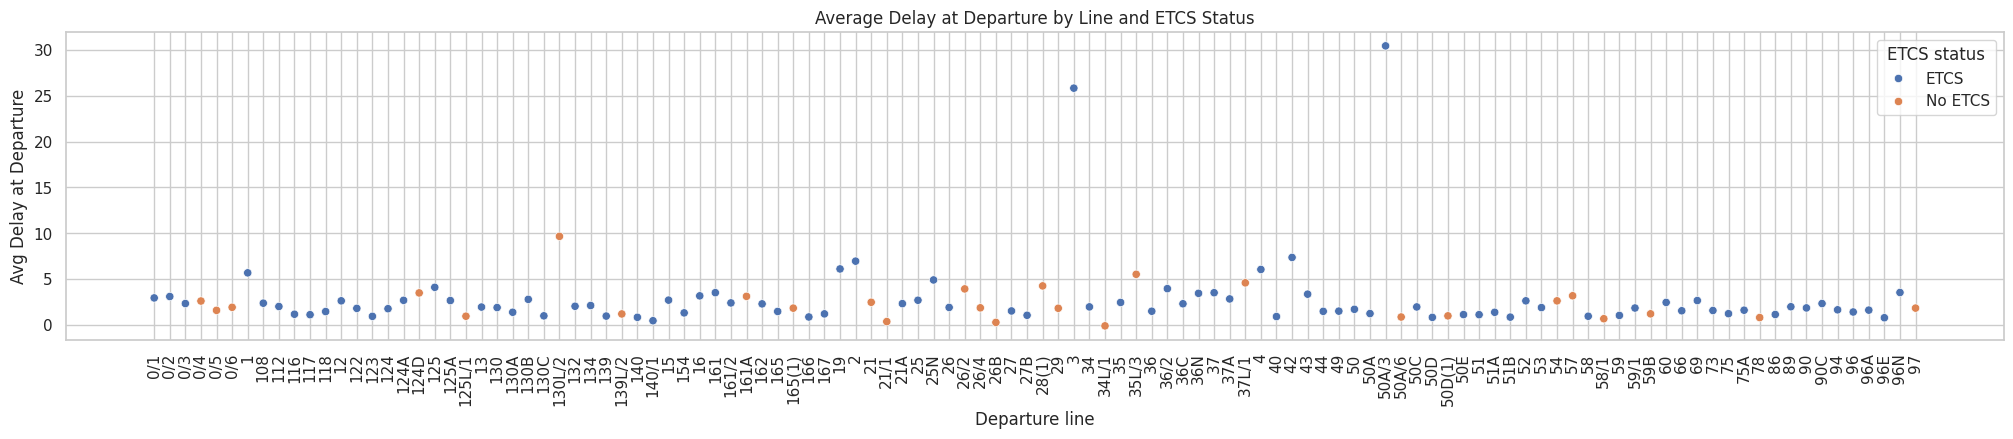

In [37]:


# Scatter plot for Average Delay at Departure vs Line

#Creating a column with "Status" to know if having ETCS or not affects the delay timings
df_delay_etcs['ETCS status'] = df_delay_etcs['ETCS level'].apply(lambda x: 'No ETCS' if x=="No ETCS" else 'ETCS')
plt.figure(figsize=(25, 4))
sns.scatterplot(x='Departure line', y='Avg Delay at Departure', hue='ETCS status', data=df_delay_etcs)
plt.xticks(rotation=90)
plt.title('Average Delay at Departure by Line and ETCS Status')
plt.show()


In [38]:
# It seems from the plot the samples with "No ETCS" is rather small. Let's count to confirm.
# Count the occurrences of ETCS and No ETCS
etcs_counts = df_delay_etcs['ETCS status'].value_counts()
print(etcs_counts)

ETCS status
ETCS       87
No ETCS    27
Name: count, dtype: int64


**Inference:**

From Visualization it seems ETCS implementation has no significant impact on delays over lines with ETCS. However, the sample is really small for No ECTS category. However, Let's perform Mann-Whitney U Test to confirm

* Since the sample size is less than 30, the Mann-Whitney U test (also known as the Wilcoxon rank-sum test) is more appropriate, as it is a non-parametric test that does not assume a normal distribution of the data unlike t-test.*

In [39]:
# Separate the delays based on ETCS status
etcs_delays = df_delay_etcs[df_delay_etcs['ETCS status'] == 'ETCS']['Avg Delay at Departure']
no_etcs_delays = df_delay_etcs[df_delay_etcs['ETCS status'] == 'No ETCS']['Avg Delay at Departure']

# Perform Mann-Whitney U Test
u_stat, p_value = stats.mannwhitneyu(etcs_delays, no_etcs_delays, alternative='two-sided')

# Print the results
print(f"U-statistic: {u_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpretation
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in departure delays.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in departure delays.")

U-statistic: 1253.0000
P-value: 0.6032
Fail to reject the null hypothesis: There is no significant difference in departure delays.


In [40]:
#5. There is no significant difference between ETCS and No ETCS departure delays however, does the highest delay lines corresponds to any particular ETCS level?
#----------------------------------------------------------------------------------------------------------------------------------------------------------------

# Convert delay columns to numeric, forcing errors to NaN
df_delay_etcs["Avg Delay at Departure"] = pd.to_numeric(df_delay_etcs["Avg Delay at Departure"], errors='coerce')
df_delay_etcs["Avg Delay at Arrival"] = pd.to_numeric(df_delay_etcs["Avg Delay at Arrival"], errors='coerce')

# Sort the DataFrame by average delay at departure
df_sorted = df_delay_etcs.sort_values(by="Avg Delay at Departure", ascending=False)

# Filter out rows with ETCS levels and analyze
etcs_analysis = df_sorted[['Departure line', 'Avg Delay at Departure', 'ETCS level']].dropna()

top_n = 10  # Change this to the desired number of top delays

# Sort the DataFrame by average delay at departure and get the top N lines
top_delay_lines = etcs_analysis.sort_values(by='Avg Delay at Departure', ascending=False).head(top_n)

#print("Top Delay Lines:\n", top_delay_lines[['Departure line', 'Avg Delay at Departure', 'ETCS level']])
#print(etcs_analysis)
# Extracting ETCS levels for the top delay lines
top_etcs_levels = top_delay_lines[['Departure line', 'Avg Delay at Departure', 'ETCS level']]

print("ETCS Levels for Top Delay Lines:\n", top_etcs_levels)
# Create a bar plot for top delay lines by ETCS level
color_map = {
    'ETCS L2 FS': 'gray',  # You can specify your own colors
    'ETCS L1 FS, ETCS 1+2': 'blue',
    'No ETCS': 'red',
    'ETCS L1 FS': 'green',
    'ETCS L1 FS, ETCS L1 LS': 'purple',
    # Add more mappings as needed
}
fig = px.bar(top_etcs_levels,
             x='Departure line',
             y='Avg Delay at Departure',
             color='ETCS level',
             title='Top Delay Lines and their ETCS Levels',
             labels={'Avg Delay at Departure': 'Average Departure Delay (Minutes)',
                     'Departure line': 'Departure Line'},
            color_discrete_map=color_map)

# Show the plot
fig.show()

ETCS Levels for Top Delay Lines:
    Departure line  Avg Delay at Departure              ETCS level
79          50A/3               30.450000              ETCS L2 FS
59              3               25.836667    ETCS L1 FS, ETCS 1+2
26         130L/2                9.658333                 No ETCS
73             42                7.356801  ETCS L1 FS, ETCS L1 LS
45              2                6.951823              ETCS L1 FS
44             19                6.100895              ETCS L1 LS
71              4                6.044872    ETCS 1+2, ETCS L1 FS
6               1                5.674051     TVM-430, ETCS L1 FS
63          35L/3                5.516667                 No ETCS
50            25N                4.898718              ETCS L1 FS


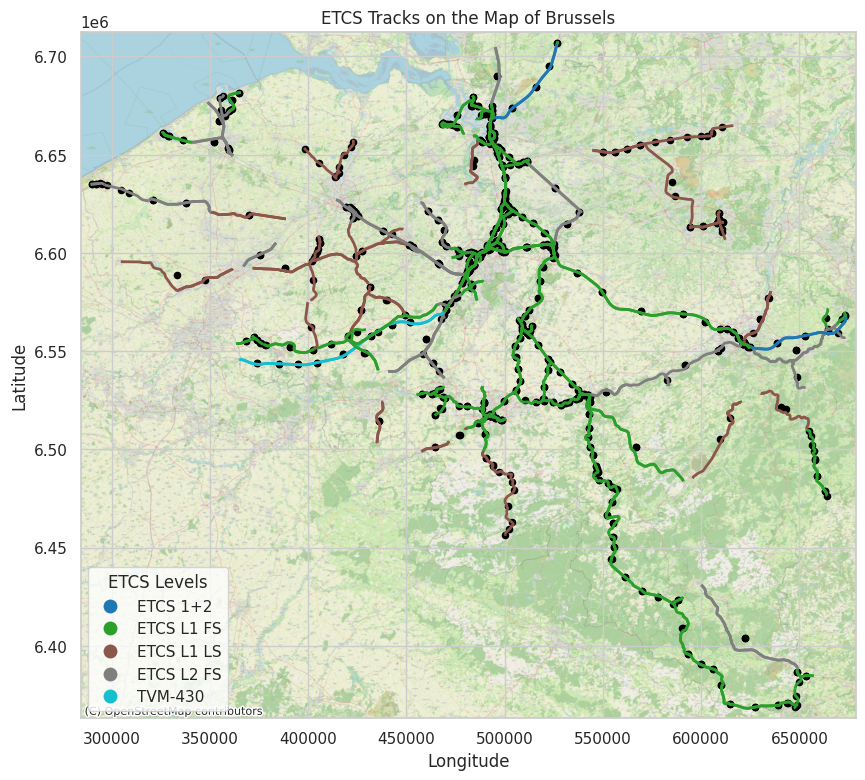

In [41]:
#Let's Visualize where ETCS L2 FS is applied
#Parse geo_point_2d for Latitude and Longitude (for station points)
df_et[['Latitude', 'Longitude']] = df_et['geo_point_2d'].str.split(',', expand=True)
df_et['Latitude'] = pd.to_numeric(df_et['Latitude'])
df_et['Longitude'] = pd.to_numeric(df_et['Longitude'])

#Create GeoDataFrame for ETCS Lines using GeoShape
def parse_geo_shape(geo_shape_str):
    """Parse GeoShape string and return LineString."""
    geo_shape_json = json.loads(geo_shape_str)
    coordinates = geo_shape_json['coordinates'][0]  # assuming 'coordinates' is a list of points
    return LineString(coordinates)

# Apply the function to create geometries for the lines
df_et['geometry'] = df_et['GeoShape'].apply(parse_geo_shape)


# Convert the DataFrame into a GeoDataFrame
gdf_tracks = gpd.GeoDataFrame(df_et, geometry='geometry', crs='EPSG:4326')

# Step 6: Create GeoDataFrame for stations (based on geo_point_2d)
stations_gdf = gpd.GeoDataFrame(df_et, geometry=gpd.points_from_xy(df_et['Longitude'], df_et['Latitude']), crs='EPSG:4326')

# Convert both GeoDataFrames to EPSG:3857 for Web Mercator projection (used by contextily)
gdf_tracks = gdf_tracks.to_crs(epsg=3857)
stations_gdf = stations_gdf.to_crs(epsg=3857)

# Step 7: Plotting the ETCS lines and stations on a Brussels basemap

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the ETCS track lines with different colors for each ETCS level
gdf_tracks.plot(
    ax=ax,
    column='ETCS level',  # Color code by 'ETCS level'
    linewidth=2,
    cmap='tab10',
    legend=True,  # Enable legend for color bar
    legend_kwds={'title': "ETCS Levels"}  # Adjust the legend title
)

# Plot the stations
stations_gdf.plot(ax=ax, color='black', marker='o', markersize=20, label='Stations')

# Add a basemap of Brussels (OpenStreetMap from contextily)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=12)

# Adjust limits to focus on the area of interest (Bounds of both tracks and stations)
combined_bounds = gdf_tracks.total_bounds  # [minx, miny, maxx, maxy]
ax.set_xlim([combined_bounds[0] - 5000, combined_bounds[2] + 5000])
ax.set_ylim([combined_bounds[1] - 5000, combined_bounds[3] + 5000])

# Set axis labels and title
plt.title('ETCS Tracks on the Map of Brussels')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()

**The analysis presents a compelling narrative regarding the relationship between ETCS levels and train delays. While line 50A/3 has the highest delays with an ETCS L2 FS designation, the more common ETCS L1 FS appears to be associated with significantly lower delays. This discrepancy underscores the need for a deeper dive into the operational dynamics at play, as well as a potential reevaluation of how ETCS systems are being utilized across different train lines.**

In [42]:
#6. Is ETCS L2 FS is the main reason for delays in line 50 A/3? Let's compare with other lines havinf the same ETCS level.
#--------------------------------------------------------------------------------------------------------------------------
# Filter rows where 'ETCS level' contains 'ETCS L2 FS'
etcs_l1_fs_rows = df_delay_etcs[df_delay_etcs['ETCS level'].str.contains("ETCS L2 FS")]

# Display the result
print(etcs_l1_fs_rows)
# Create a bar plot for average delays
fig = px.bar(etcs_l1_fs_rows,
             x='Departure line',
             y='Avg Delay at Departure',
             title='Average Departure Delays for Lines with ETCS L1 FS',
             labels={'Avg Delay at Departure': 'Average Delay at Departure (Minutes)',
                     'Departure line': 'Departure Line'},
             color='Avg Delay at Departure',
             color_continuous_scale=px.colors.sequential.Viridis)

# Show the plot
fig.show()

    Departure line  Avg Delay at Departure  Avg Delay at Arrival   Line  \
10             117                1.107463              1.184129    117   
12              12                2.620035              2.498123     12   
13             122                1.795949              1.962326    122   
18             125                4.094538              4.023087    125   
19            125A                2.651276              2.942602   125A   
35              16                3.162727              3.105286     16   
39             162                2.287618              2.189879    162   
51              26                1.900331              1.784997     26   
62              35                2.442829              2.329153     35   
68              37                3.504081              3.389626     37   
75              44                1.473333              1.450000     44   
76              49                1.495556              1.648889     49   
77              50       

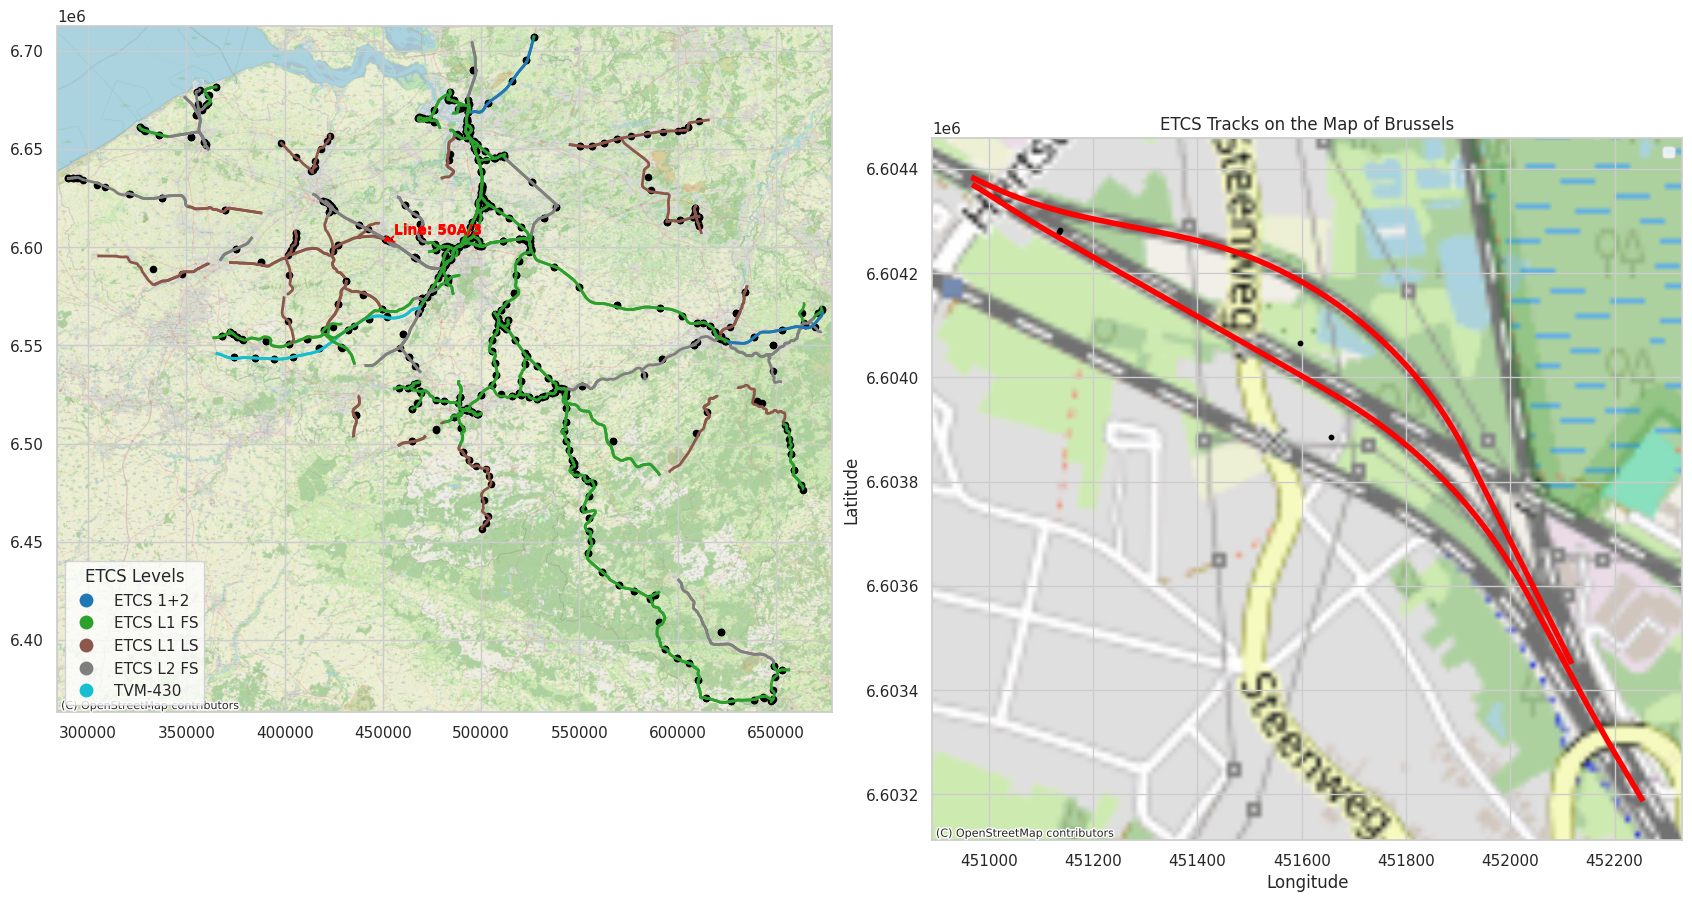

In [46]:

# Apply the function to create geometries for the lines
df_et['geometry'] = df_et['GeoShape'].apply(parse_geo_shape)

# Convert the DataFrame into a GeoDataFrame
gdf_tracks = gpd.GeoDataFrame(df_et, geometry='geometry', crs='EPSG:4326')

# Create GeoDataFrame for stations (based on geo_point_2d)
stations_gdf = gpd.GeoDataFrame(df_et, geometry=gpd.points_from_xy(df_et['Longitude'], df_et['Latitude']), crs='EPSG:4326')

# Convert both GeoDataFrames to EPSG:3857 for Web Mercator projection (used by contextily)
gdf_tracks = gdf_tracks.to_crs(epsg=3857)
stations_gdf = stations_gdf.to_crs(epsg=3857)

# Create a figure and main axis
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the ETCS track lines with different colors for each ETCS level
gdf_tracks.plot(
    ax=ax,
    column='ETCS level',  # Color code by 'ETCS level'
    linewidth=2,
    cmap='tab10',
    legend=True,  # Enable legend for color bar
    legend_kwds={'title': "ETCS Levels"}  # Adjust the legend title
)

# Highlight line 50A/3 with a different color
highlight_line = gdf_tracks[gdf_tracks['Line'] == '50A/3']
line_bounds = highlight_line.total_bounds  # This returns [minx, miny, maxx, maxy]
highlight_line.plot(ax=ax, color='red', linewidth=4, label='Highlighted Line 50A/3')



# Plot the stations
stations_gdf.plot(ax=ax, color='black', marker='o', markersize=20, label='Stations')

# Add a basemap of Brussels (OpenStreetMap from contextily)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=12)

# Adjust limits to focus on the area of interest (Bounds of both tracks and stations)
combined_bounds = gdf_tracks.total_bounds  # [minx, miny, maxx, maxy]
ax.set_xlim([combined_bounds[0] - 5000, combined_bounds[2] + 5000])
ax.set_ylim([combined_bounds[1] - 5000, combined_bounds[3] + 5000])
# Create inset axis for zoom plot
inset_ax = fig.add_axes([1, 0.0, 0.75, 0.75])  # [left, bottom, width, height]

# Plot the zoomed-in view of the highlighted line
highlight_line.plot(ax=inset_ax, color='red', linewidth=4)
stations_gdf.plot(ax=inset_ax, color='black', marker='o', markersize=10)

# Set the limits of the inset to be the same as the line's bounds with less padding
inset_ax.set_xlim([line_bounds[0] - 75, line_bounds[2] + 75])  # Less padding for the inset
inset_ax.set_ylim([line_bounds[1] - 75, line_bounds[3] + 75])  # Less padding for the inset

# Add a basemap to the inset
ctx.add_basemap(inset_ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=14)

# Add annotations in the main plot
for _, row in highlight_line.iterrows():
    # Annotate the line with its name or any other relevant information
    ax.annotate(
        f'Line: {row["Line"]}',
        xy=row.geometry.coords[0],  # Position of annotation
        xytext=(5, 5),  # Offset for annotation
        textcoords='offset points',
        fontsize=10,
        color='red',
        weight='bold',
        arrowprops=dict(arrowstyle='->', color='red')
    )

# Set axis labels and title for main plot
plt.title('ETCS Tracks on the Map of Brussels')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.legend()
plt.show()


**From the plot it's nothing conclusive but the division and reconnection of line 50A/3 could indeed be contributing factors to the average delays observed. It would be beneficial to further investigate the specific characteristics of this track section, including maintenance records, traffic patterns, and operational efficiency.**

In [48]:
#7.Is there any relation with the lenth of the tracks to the delay minutes?
#------------------------------------------------------------------------------------------------------------
# Apply the function to create geometries for the lines
df_et['geometry'] = df_et['GeoShape'].apply(parse_geo_shape)

# Convert the DataFrame into a GeoDataFrame
gdf_tracks = gpd.GeoDataFrame(df_et, geometry='geometry', crs='EPSG:4326')

# Calculate lengths of the tracks
gdf_tracks['Length'] = gdf_tracks.length  # Length in degrees (geodetic)

# If you want to convert to meters, transform to a projected CRS first (e.g., UTM)
gdf_tracks = gdf_tracks.to_crs(epsg=3857)  # Convert to Web Mercator (meters)
gdf_tracks['Length_m'] = gdf_tracks.length  # Length in meters

# Display the DataFrame with lengths
print(gdf_tracks[['ID','ETCS level','Line','Track' ,'Length', 'Length_m']])

      ID  ETCS level Line  Track    Length      Length_m
0      6  ETCS L1 FS   13      1  0.019280   2545.816320
1      8  ETCS L1 FS   13      1  0.048657   5453.847767
2      9  ETCS L1 FS   15      2  0.018291   2379.565531
3     13  ETCS L1 FS   15      2  0.030970   3644.092924
4     16  ETCS L1 FS   15      1  0.013529   1659.117074
..   ...         ...  ...    ...       ...           ...
868  891  ETCS L1 FS  50A      2  0.084653   9598.456776
869  892  ETCS L1 FS  50A      1  0.084673   9600.625543
870  894  ETCS L1 FS  51B      1  0.110021  14737.715527
871  898  ETCS L1 FS   42      1  0.052424   7848.794544
872  899  ETCS L1 FS  162      2  0.015774   2528.740330

[873 rows x 6 columns]


<ipython-input-48-2b07b44faa59>:10: UserWarning:

Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




In [49]:
# Group by 'Line' and aggregate the total distance and unique ETCS levels
df_dist = gdf_tracks.groupby('Line').agg({
    'Length_m': 'sum'  # Sum the lengths of tracks in meters
}).reset_index()

# Rename the columns for clarity
df_dist.rename(columns={'Length_m': 'Total_Length_m'}, inplace=True)

# Display the resulting DataFrame
print(df_dist)


    Line  Total_Length_m
0     01    12301.727852
1     02    12068.100111
2     03    13851.285706
3      1   230800.471437
4    1/1     2253.199188
..   ...             ...
159  96B     6549.254101
160  96C     1624.755127
161  96D     2528.370463
162  96E     4401.640783
163  96N    46042.423086

[164 rows x 2 columns]


In [50]:
df_dist['Line'] = df_dist['Line'].replace({
    '01': '0/1',
    '02': '0/2',
    '03': '0/3'
})

In [51]:
#Merging with df_delay_etcs to see effects with the distance
df_length = pd.merge(df_delay_etcs,df_dist, on ='Line', how='left' )

In [52]:
df_length

Departure line  Avg Delay at Departure  Avg Delay at Arrival Line  \
0              0/1                2.936942              2.612132  0/1   
1              0/2                3.089934              2.954107  0/2   
2              0/3                2.323640              2.110169  0/3   
3              0/4                2.599294              2.395766  NaN   
4              0/5                1.582209              1.380410  NaN   
..             ...                     ...                   ...  ...   
109             96                1.401073              1.322723   96   
110            96A                1.605797              1.605797  96A   
111            96E                0.773656              0.771237  96E   
112            96N                3.528862              3.444309  96N   
113             97                1.826526              1.323309  NaN   

                             ETCS level ETCS status  Total_Length_m  
0                            ETCS L1 FS        ETCS    12301.727852  
1                            ETCS L1 FS        ETCS    12068.100111  
2                            ETCS L1 FS        ETCS    13851.285706  
3                               No ETCS     No ETCS             NaN  
4                               No ETCS     No ETCS             NaN  
..                                  ...         ...             ...  
109  ETCS L1 LS, ETCS L2 FS, ETCS L1 FS        ETCS   188667.899690  
110                          ETCS L1 FS        ETCS     3140.630825  
111              ETCS L2 FS, ETCS L1 FS        ETCS     4401.640783  
112                          ETCS L1 FS        ETCS    46042.423086  
113                             No ETCS     No ETCS             NaN  

[114 rows x 7 columns]

                        Total_Length_m  Avg Delay at Departure  \
Total_Length_m                1.000000                0.030800   
Avg Delay at Departure        0.030800                1.000000   
Avg Delay at Arrival          0.026463                0.990542   

                        Avg Delay at Arrival  
Total_Length_m                      0.026463  
Avg Delay at Departure              0.990542  
Avg Delay at Arrival                1.000000  


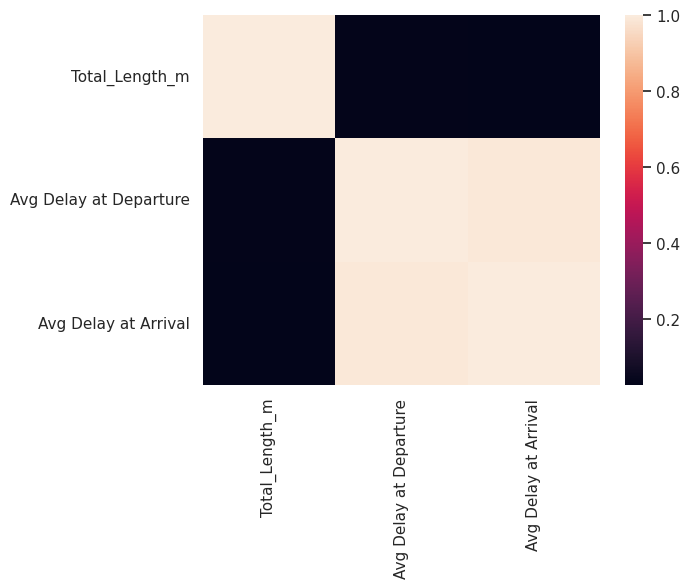

In [53]:
# Calculate correlation matrix to quantify the relationship between the total length and delays.
correlation = df_length[['Total_Length_m', 'Avg Delay at Departure', 'Avg Delay at Arrival']].corr()
sns.heatmap(correlation)
print(correlation)

**The weak correlation values suggest that track length is not a significant factor influencing delays in this dataset. Other factors might have a more substantial impact on delays, such as operational issues, signal issues, weather conditions, or scheduling efficiency.**

In [54]:
import warnings
warnings.filterwarnings("ignore")

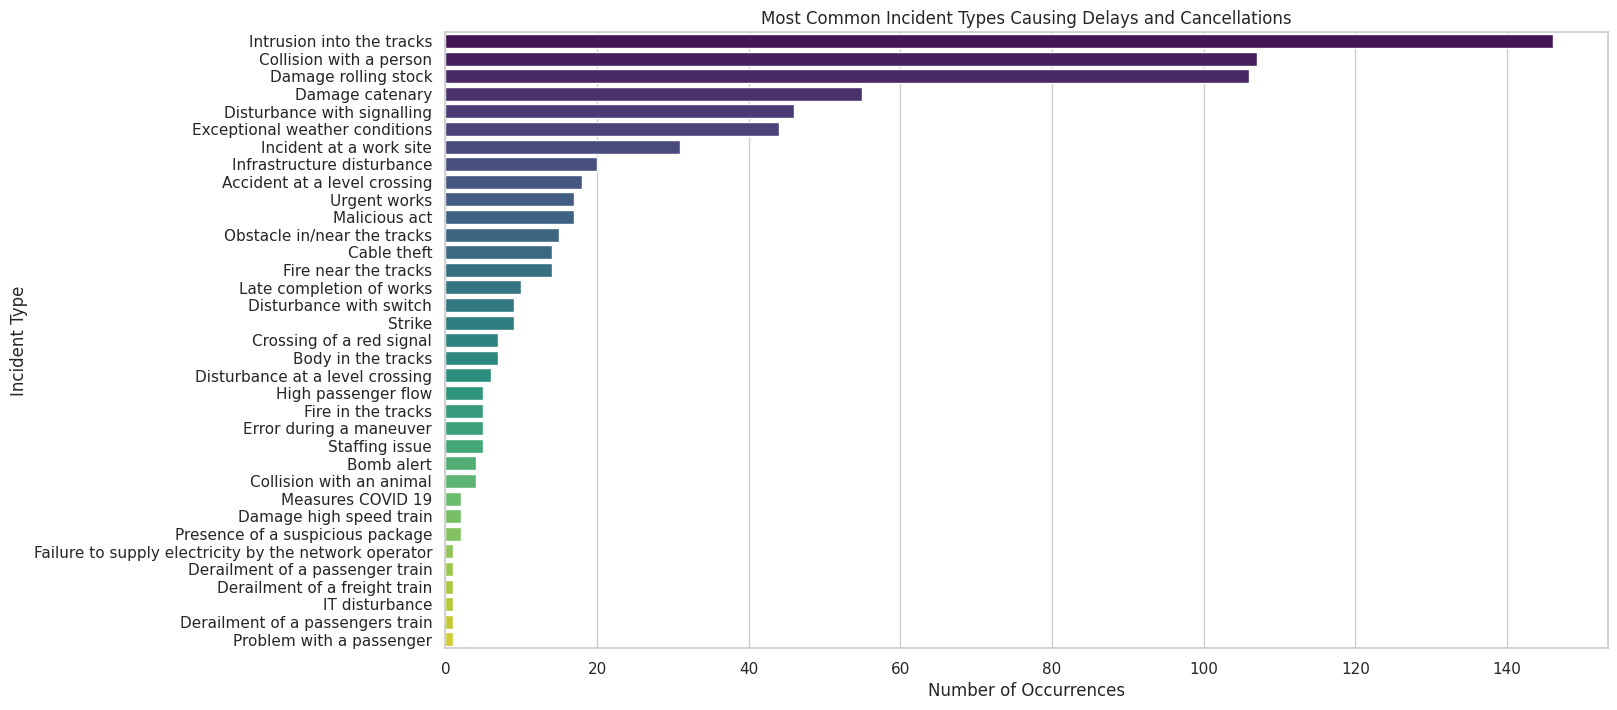

In [55]:
#8. What are the most common types of incidents causing delays and cancellations? Which incidents lead to more severe disruptions?
#-------------------------------------------------------------------------------------------------------------------------------------
# Grouping data by Incident Description and counting occurrences
incident_counts = df_inc['Incident description.2'].value_counts()

# Plot
plt.figure(figsize=(15, 8))
sns.barplot(x=incident_counts.values, y=incident_counts.index, palette='viridis')
plt.title('Most Common Incident Types Causing Delays and Cancellations')
plt.xlabel('Number of Occurrences')
plt.ylabel('Incident Type')
plt.show()

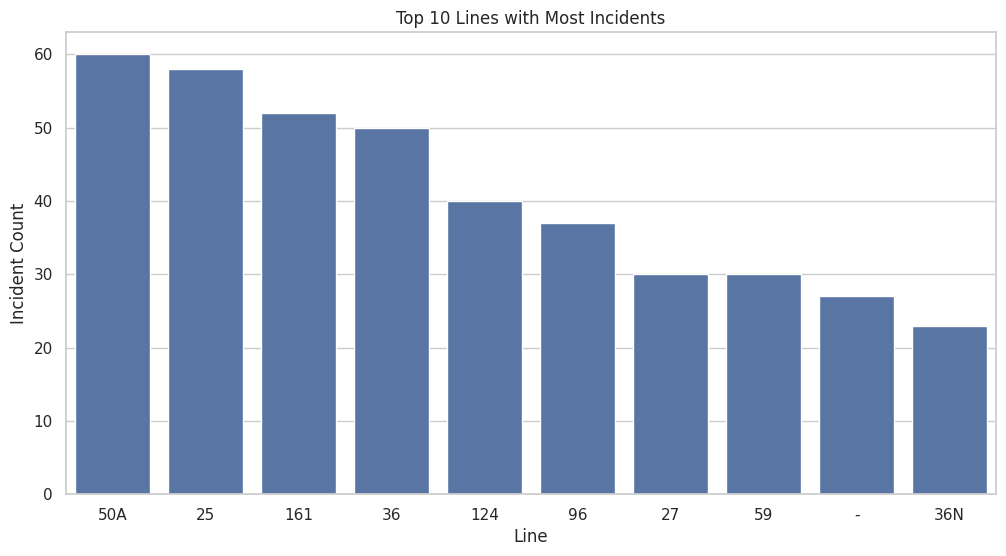

In [56]:
#9. What are the top lines with most incidents?
#-------------------------------------------------------------------------------------
# Count incidents by line
line_incidents = df_inc['Line'].value_counts()

# Plot the top 10 lines with the most incidents
plt.figure(figsize=(12, 6))
sns.barplot(x=line_incidents.head(10).index, y=line_incidents.head(10).values)
plt.title('Top 10 Lines with Most Incidents')
plt.xlabel('Line')
plt.ylabel('Incident Count')
plt.xticks(rotation=0)
plt.show()

In [57]:
#Identify the incident hotspots
# Step 1: Group by Line
incident_summary = df_inc.groupby("Line").agg({
    "Incident date": "count",  # Count incidents
    "Minutes of delay": "mean",  # Sum delays
    "Number of cancelled trains": "sum"  # Sum cancellations
}).rename(columns={"Incident date": "Incident Count"})

# Step 2: Identify hotspots
# Setting thresholds for hotspots, e.g., more than 5 incidents or more than 2000 minutes of delay
incident_threshold = 10
#delay_threshold = 2000

hotspots = incident_summary[
    (incident_summary["Incident Count"] > incident_threshold)
]

# Display hotspots

hotspots = hotspots.reset_index()
print(hotspots)

   Line  Incident Count  Minutes of delay  Number of cancelled trains
0     -              27       8281.555556                        8076
1   0/1              19       3137.789474                         663
2   0/3              12       1868.833333                         194
3   124              40       1736.875000                        1822
4    15              18       1503.111111                         699
5   161              52       1855.596154                        2605
6    25              58       2529.379310                        2729
7    26              11       1512.818182                         386
8    27              30       1702.200000                        1445
9    35              19       1625.842105                         901
10   36              50       2064.380000                        2095
11  36N              23       2736.652174                        1367
12   50              17       2230.000000                         745
13  50A             

In [58]:
top_lines

Departure line  avg_delay_departure  avg_delay_arrival  \
79          50A/3            30.450000          29.266667   
59              3            25.836667          25.836667   
26         130L/2             9.658333           4.925000   
73             42             7.356801           7.372272   
45              2             6.951823           7.068490   
44             19             6.100895           5.747204   
71              4             6.044872           5.614103   
6               1             5.674051           5.674051   
63          35L/3             5.516667           5.516667   
50            25N             4.898718           4.511859   

                        corresponding_stopping_places  
79                                        DENDERLEEUW  
59                                             CHENEE  
26                                           CHATELET  
73  TROIS-PONTS, GOUVY, RIVAGE, AYWAILLE, STOUMONT...  
45                                        LEUVEN, ANS  
44  OVERPELT, NEERPELT, BALEN-WERKPLAATSEN, LOMMEL...  
71                                      NOORDERKEMPEN  
6                                               HALLE  
63                                    LEUVEN-BUNDEL M  
50                                           MECHELEN

In [59]:
#Let's visualize in the map

# Color mapping based on ETCS levels
color_map = {
    "ETCS L1 FS": "blue",
    "ETCS L2 FS": "orange",
    'ETCS L1 LS': "yellow",
    'ETCS 1+2': "green",
    'TVM-430' :"cyan"

}

# Create a Folium map centered around Belgium
belgium_map = folium.Map(location=[50.8503, 4.3517], zoom_start=8)

 # Coordinates for the top 10 stopping places (approximate values)
places_coordinates = {
    'HERGENRATH': [50.7115, 6.0116],
    'GOUVY': [50.1899, 5.9335],
    'VIELSALM': [50.2791, 5.9241],
    'COO': [50.3943, 5.8998],
    'TROIS-PONTS': [50.3761, 5.8663],
    'AYWAILLE': [50.4751, 5.6761],
    'STOUMONT': [50.4454, 5.8261],
    'OVERPELT': [51.2142, 5.4486],
    'LOMMEL': [51.2300, 5.3139],
    'NOORDERKEMPEN': [51.3465, 4.7126]
}

  # Top 10 stopping places with average departure delays
top_10_places = [
    ('HERGENRATH', 15.406818),
    ('GOUVY', 8.388172),
    ('VIELSALM', 7.832381),
    ('COO', 7.830476),
    ('TROIS-PONTS', 7.279524),
    ('AYWAILLE', 7.188571),
    ('STOUMONT', 6.954762),
    ('OVERPELT', 6.538725),
    ('LOMMEL', 6.451471),
    ('NOORDERKEMPEN', 6.044872)
]
#Top lines with delays
top_10_lines = top_lines["Departure line"].tolist()

#Icident hotspots
incidents = hotspots["Line"].tolist()
    # Add circles for each place with delays
for place, delay in top_10_places:
    folium.CircleMarker(
        location=places_coordinates[place],
        radius=delay *3,  # Scale radius by delay
        popup=f'{place}: {delay:.2f} minutes delay',
        color='red',
        fill=True,
        fill_color='red'
    ).add_to(belgium_map)

# Track the lines already plotted for incidents
plotted_lines = set()

# Plot lines on the map
for index, entry in df_et.iterrows():
    # Extract coordinates from GeoShape
    coordinates = json.loads(entry["GeoShape"])["coordinates"][0]

    # Create a list of points for the polyline
    points = [(lat, lon) for lon, lat in coordinates]

    # Get the ETCS level and color
    etcs_level = entry["ETCS level"]
    color = color_map.get(etcs_level, "gray")  # Default to gray if not found

    # Create a polyline for the line
    folium.PolyLine(
        locations=points,
        color=color,
        weight=5,
        opacity=0.7,
        popup=f'Line: {entry["Line"]}, Track: {entry["Track"]}, ID: {entry["ID"]}'
    ).add_to(belgium_map)

    # Check if the line is in the top lines
    if entry["Line"] in top_10_lines:
        # Calculate midpoint of the coordinates
        mid_index = len(points) // 2
        midpoint = points[mid_index]

        # Add a marker at the midpoint
        folium.Marker(
            location=midpoint,
            popup=f'Top Line: {entry["Line"]}',
            icon=folium.Icon(color='lightred', icon='info-sign')
        ).add_to(belgium_map)

    # Check if the line is an incident hotspot and has not been plotted yet
    if entry["Line"] in incidents and entry["Line"] not in plotted_lines:
        r = hotspots.loc[hotspots.Line == entry["Line"]]
        # Calculate midpoint of the coordinates
        mid_index = len(points) // 2
        midpoint = points[mid_index]

        # Add a marker at the midpoint (only once per line)
        folium.CircleMarker(
            location=midpoint,
            radius=int(r["Incident Count"]) ,
            popup=f'Hotspot: {entry["Line"]}',
            color='magenta',
            fill=True,
            fill_color='magenta'
        ).add_to(belgium_map)

        # Mark the line as plotted
        plotted_lines.add(entry["Line"])

# Save the map to an HTML file
belgium_map.save("belgium_etcs_map.html")

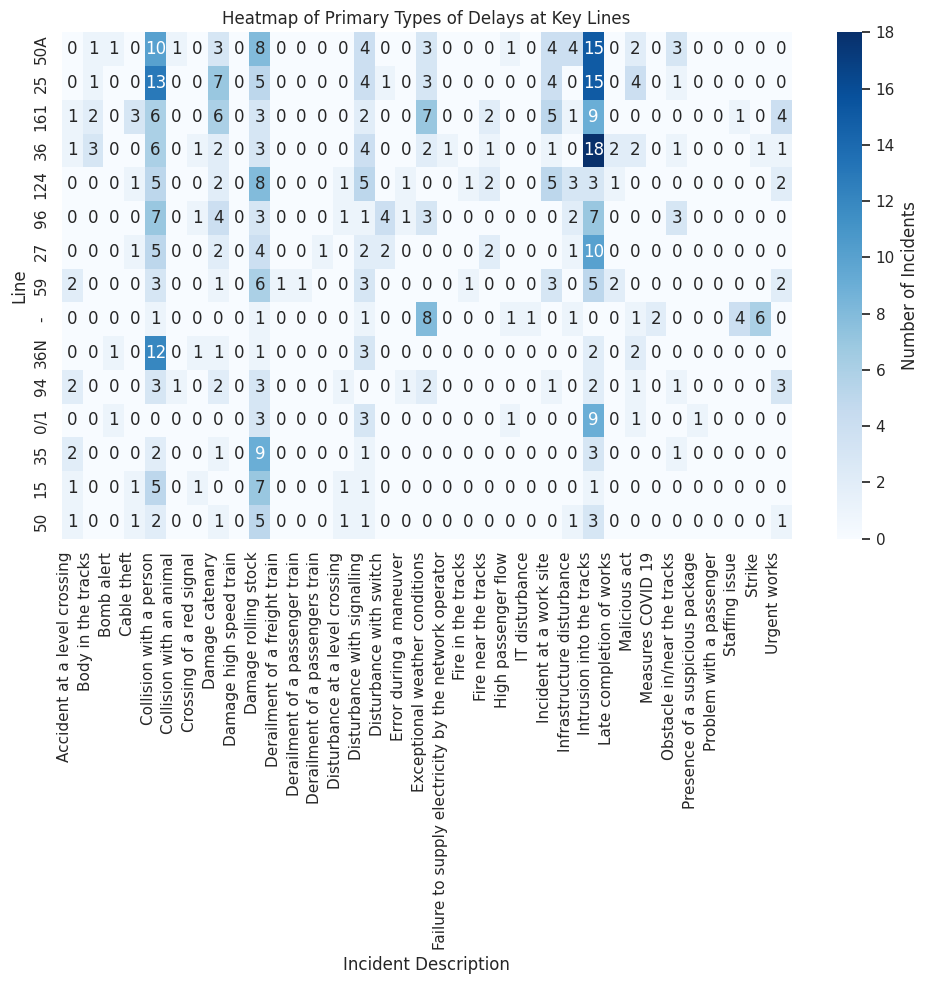

In [60]:
# Group incidents by line and Incident description
station_delay_counts = df_inc.groupby(['Line', 'Incident description.2']).size().unstack(fill_value=0)

# Identify key lines (top 10 lines with the most incidents)
top_lines = station_delay_counts.sum(axis=1).nlargest(15).index

# Filter for only the top stations
top_line_delays = station_delay_counts.loc[top_lines]

# Ensure that all values are numeric
top_line_delays = top_line_delays.apply(pd.to_numeric, errors='coerce')

# Plotting Heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(top_line_delays, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Number of Incidents'})
plt.title('Heatmap of Primary Types of Delays at Key Lines')
plt.xlabel('Incident Description')
plt.ylabel('Line')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()



<Figure size 1500x1500 with 0 Axes>

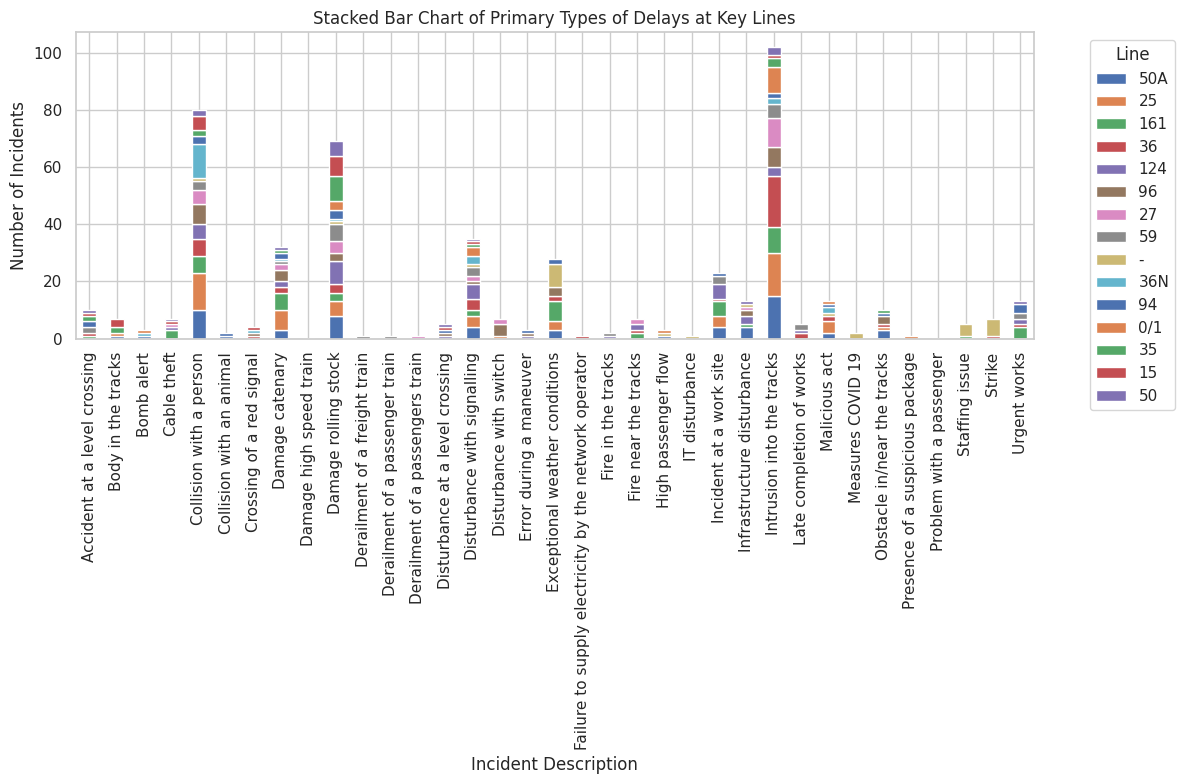

In [61]:
#Alternate idea
# Convert data for stacked bar chart
stacked_data = top_line_delays.T  # Transpose for better plotting

# Plotting Stacked Bar Chart
plt.figure(figsize=(15, 15))
stacked_data.plot(kind='bar', stacked=True, figsize=(12, 8))

plt.title('Stacked Bar Chart of Primary Types of Delays at Key Lines')
plt.xlabel('Incident Description')
plt.ylabel('Number of Incidents')
plt.legend(title='Line', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [62]:
#10. Does ETCS has anything to do with incidents?
#---------------------------------------------------------------------------------------
#merging the datasets to see if ECTS has any impacts with the incidents
df_inc_ects = pd.merge(df_inc, df_length, left_on="Line",right_on ="Departure line" ,how ='left')

In [63]:
df_inc_ects.head()

Month Incident date Line_x          Place         Place.1  \
0  2019-01    2019-01-15    50A    Y.MEULEWIJK     Y.MEULEWIJK   
1  2019-01    2019-01-15    0/2  BRUSSEL-NOORD  BRUXELLES-NORD   
2  2019-01    2019-01-17    50A        BEERNEM         BEERNEM   
3  2019-01    2019-01-18    161    GROENENDAAL     GROENENDAAL   
4  2019-02    2019-02-01     27      VILVOORDE       VILVOORDE   

          Place.2                Incident description  \
0     Y.MEULEWIJK                 Schade bovenleiding   
1  BRUSSELS-NORTH                         Spoorlopers   
2         BEERNEM                     Persoonsongeval   
3     GROENENDAAL  Uitzonderlijke weersomstandigheden   
4       VILVOORDE                         Spoorlopers   

                       Incident description.1          Incident description.2  \
0                            Avarie caténaire                 Damage catenary   
1                    Intrusion dans les voies       Intrusion into the tracks   
2                        Heurt d'une personne         Collision with a person   
3  Conditions météorologiques exceptionnelles  Exceptional weather conditions   
4                    Intrusion dans les voies       Intrusion into the tracks   

   Minutes of delay  Number of cancelled trains Departure line  \
0              1776                          23            50A   
1              2799                          22            0/2   
2              1214                          35            50A   
3              4388                          89            161   
4              1411                          16             27   

   Avg Delay at Departure  Avg Delay at Arrival Line_y  \
0                1.229638              1.117016    50A   
1                3.089934              2.954107    0/2   
2                1.229638              1.117016    50A   
3                3.510569              3.337205    161   
4                1.514574              1.358565     27   

               ETCS level ETCS status  Total_Length_m  
0  ETCS L2 FS, ETCS L1 FS        ETCS   245689.386383  
1              ETCS L1 FS        ETCS    12068.100111  
2  ETCS L2 FS, ETCS L1 FS        ETCS   245689.386383  
3              ETCS L1 FS        ETCS   109514.179221  
4              ETCS L1 FS        ETCS   131464.725697

In [64]:
#for simplicity I am filling the empty columns with No ECTS
df_inc_ects["ETCS level"] = df_inc_ects["ETCS level"].fillna("No ETCS")


In [65]:
df_inc_ects.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 738 entries, 0 to 737
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Month                       738 non-null    object        
 1   Incident date               738 non-null    datetime64[ns]
 2   Line_x                      738 non-null    object        
 3   Place                       738 non-null    object        
 4   Place.1                     738 non-null    object        
 5   Place.2                     738 non-null    object        
 6   Incident description        738 non-null    object        
 7   Incident description.1      738 non-null    object        
 8   Incident description.2      738 non-null    object        
 9   Minutes of delay            738 non-null    int64         
 10  Number of cancelled trains  738 non-null    int64         
 11  Departure line              698 non-null    object        

In [66]:
#showing the null value columns
# Step 1: Create a boolean mask for missing values
missing_mask = df_inc_ects.isnull().any(axis=1)

# Step 2: Filter the DataFrame to show rows with at least one null value
rows_with_nulls = df_inc_ects[missing_mask]

# Display the rows with null values
print("Rows with null values:")
print(rows_with_nulls)

Rows with null values:
       Month Incident date Line_x             Place            Place.1  \
6    2019-02    2019-02-12      -                 -                  -   
11   2019-03    2019-03-10      -                 -                  -   
31   2019-09    2019-09-18    0/4  BRUSSEL-CENTRAAL  BRUXELLES-CENTRAL   
38   2019-10    2019-10-30  36C/2   Y.MACHELEN-ZUID    Y.MACHELEN-ZUID   
39   2019-11    2019-11-20    0/5  BRUSSEL-CENTRAAL  BRUXELLES-CENTRAL   
..       ...           ...    ...               ...                ...   
680  2023-04    2023-04-19    0/4     BRUSSEL-NOORD     BRUXELLES-NORD   
684  2023-04    2023-04-29   10/1         Y.MELSELE          Y.MELSELE   
686  2023-05    2023-05-17     97         QUAREGNON          QUAREGNON   
712  2024-01    2024-01-08     97          JEMAPPES           JEMAPPES   
728  2024-05    2024-05-16   26/4         ETTERBEEK          ETTERBEEK   

              Place.2                Incident description  \
6                   -      

In [67]:
#incident_line_counts

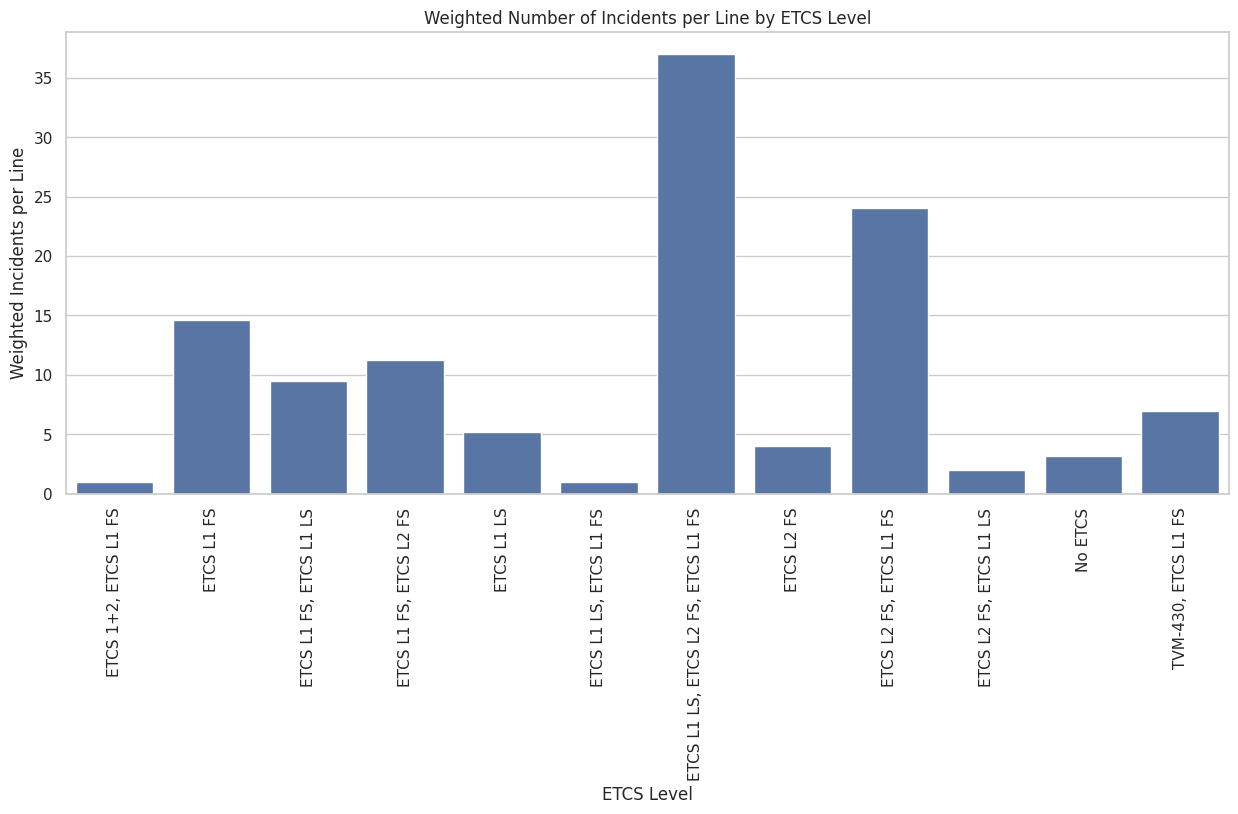

In [68]:
# Group by 'ETCS level' and count the total number of incidents
incident_counts = df_inc_ects.groupby('ETCS level').size().reset_index(name='Total Incidents')

# Count the number of unique lines for each ETCS level
line_counts = df_inc_ects.groupby('ETCS level')['Line_x'].nunique().reset_index(name='Number of Lines')

# Merge the two dataframes to get incidents and lines together
incident_line_counts = pd.merge(incident_counts, line_counts, on='ETCS level')

# Calculate the weighted number of incidents per line
incident_line_counts['Weighted Incidents per Line'] = incident_line_counts['Total Incidents'] / incident_line_counts['Number of Lines']

# Plot the weighted number of incidents per line by ETCS level
plt.figure(figsize=(15, 6))
sns.barplot(data=incident_line_counts, x='ETCS level', y='Weighted Incidents per Line', order=incident_line_counts['ETCS level'].value_counts().index)
plt.title('Weighted Number of Incidents per Line by ETCS Level')
plt.xticks(rotation=90)
plt.xlabel('ETCS Level')
plt.ylabel('Weighted Incidents per Line')
plt.show()

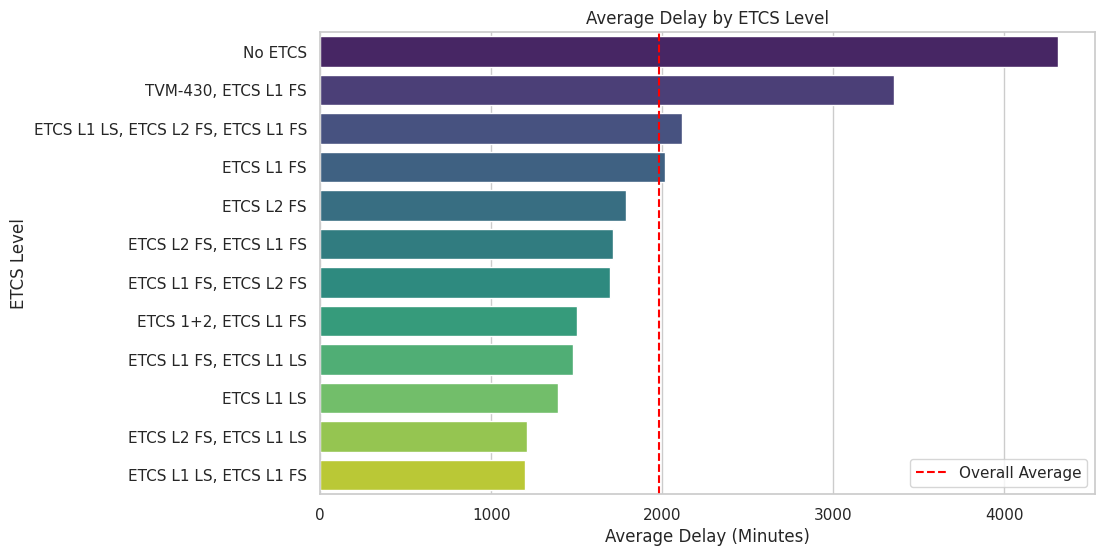

In [69]:

# Group by ETCS level and calculate average delay
etcs_delay = df_inc_ects.groupby('ETCS level')['Minutes of delay'].agg(['mean', 'sum', 'count']).reset_index()

# Rename columns
etcs_delay.columns = ['ETCS Level', 'Average Delay (Minutes)', 'Total Delay (Minutes)', 'Incident Count']

# Sort values by Average Delay for visualization
etcs_delay = etcs_delay.sort_values(by='Average Delay (Minutes)', ascending=False)

# Plot the average delay by ETCS level
plt.figure(figsize=(10, 6))
sns.barplot(x='Average Delay (Minutes)', y='ETCS Level', data=etcs_delay, palette='viridis')
plt.title('Average Delay by ETCS Level')
plt.axvline(etcs_delay['Average Delay (Minutes)'].mean(), color='red', linestyle='--', label='Overall Average')
plt.legend()
plt.show()

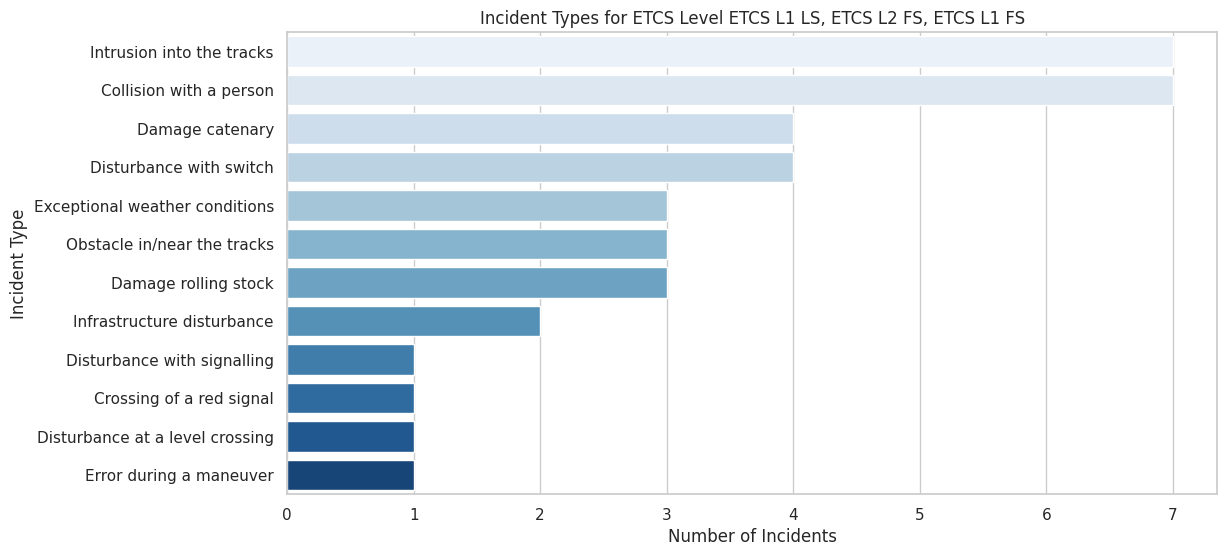

In [70]:
# Filter rows where 'ETCS level' contains 'ETCS L1 FS'
etcs_l1_fs_incidents = df_inc_ects[df_inc_ects['ETCS level'].str.contains("ETCS L1 LS, ETCS L2 FS, ETCS L1 FS")]

# Step 2: Count occurrences of each incident type
incident_counts = etcs_l1_fs_incidents['Incident description.2'].value_counts().reset_index()
incident_counts.columns = ['Incident Type', 'Count']

# Step 3: Plot the results
plt.figure(figsize=(12, 6))
sns.barplot(data=incident_counts, x='Count', y='Incident Type', palette='Blues')
plt.title('Incident Types for ETCS Level ETCS L1 LS, ETCS L2 FS, ETCS L1 FS')
plt.xlabel('Number of Incidents')
plt.ylabel('Incident Type')
plt.show()

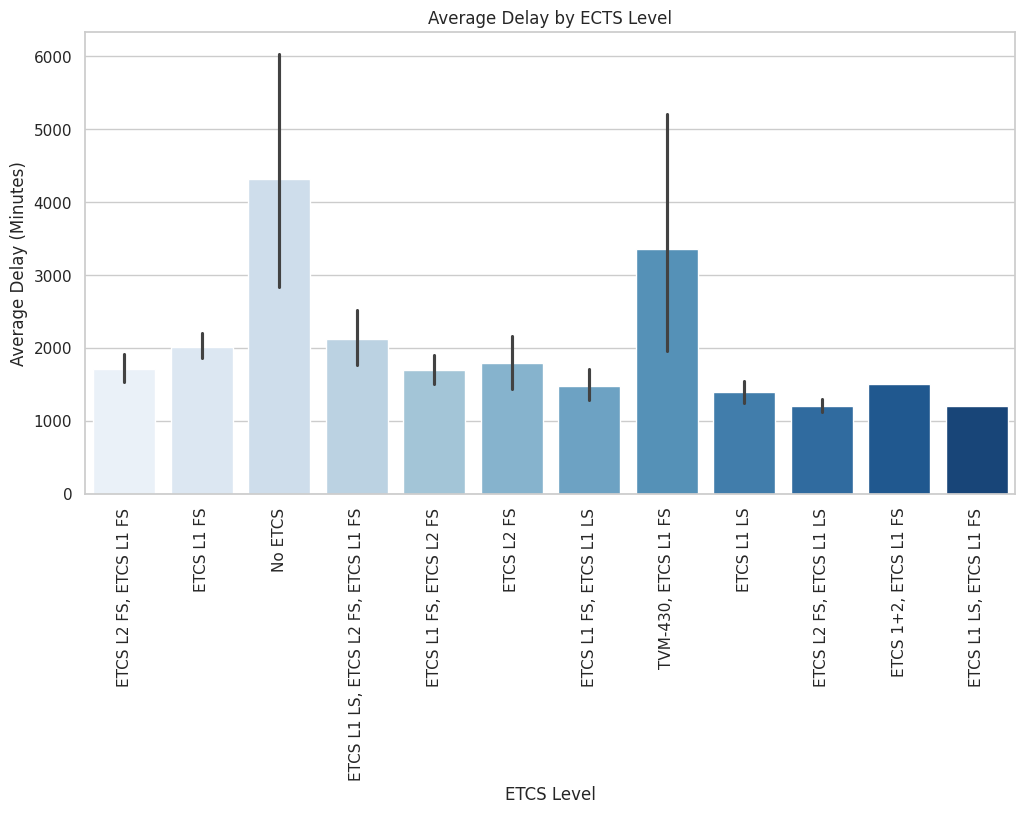

In [71]:
#11. Does ECTS helps in the recovery time after an accident?
#------------------------------------------------------------------------------
plt.figure(figsize=(12, 6))
sns.barplot(data=df_inc_ects, x='ETCS level', y='Minutes of delay', estimator=np.mean, palette='Blues')
plt.title('Average Delay by ECTS Level')
plt.ylabel('Average Delay (Minutes)')
plt.xlabel('ETCS Level')
plt.xticks(rotation=90)
plt.show()

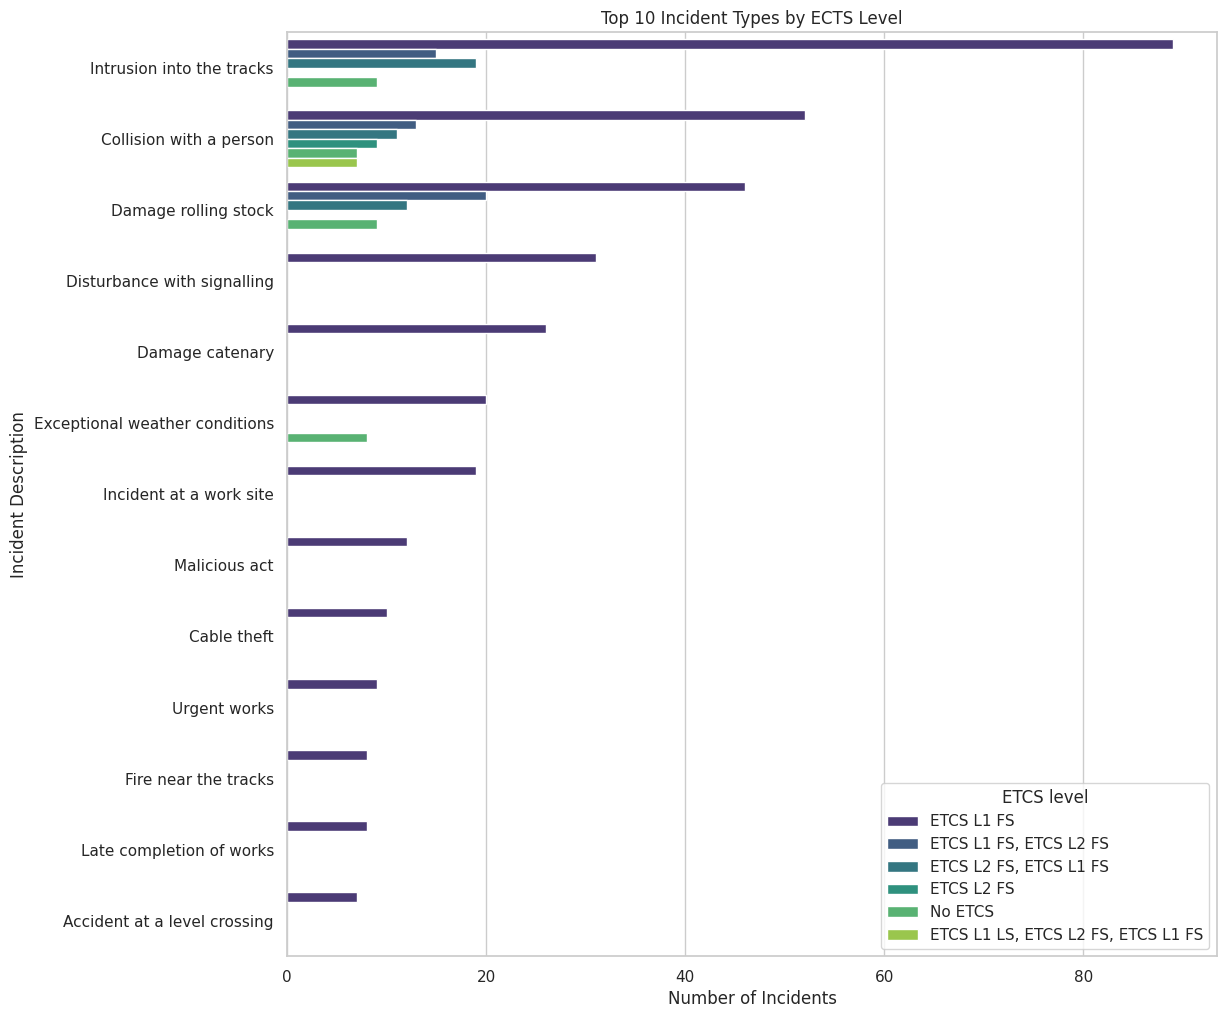

In [72]:
# Count the incidents by description and ECTS level
incident_types = df_inc_ects.groupby(['Incident description.2', 'ETCS level']).size().reset_index(name='Counts')

# Plotting the top incident types
top_incidents = incident_types.nlargest(25, 'Counts')

plt.figure(figsize=(12, 12))
sns.barplot(data=top_incidents, x='Counts', y='Incident description.2', hue='ETCS level', palette='viridis')
plt.title('Top 10 Incident Types by ECTS Level')
plt.xlabel('Number of Incidents')
plt.ylabel('Incident Description')
plt.show()

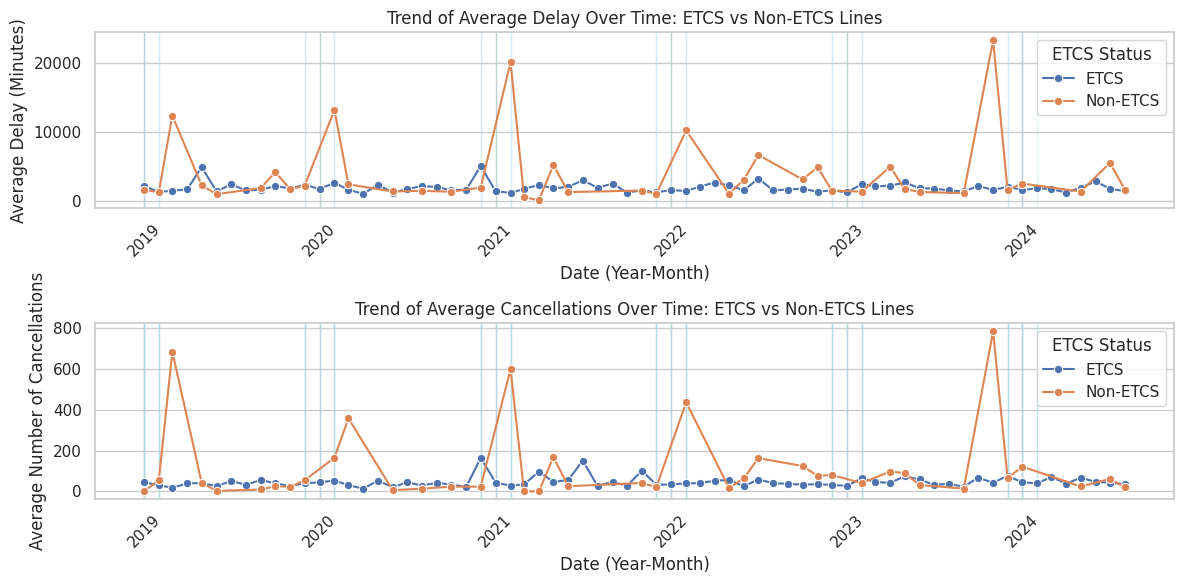

In [73]:
#12. Does the ECTS helps improving punctuality over time?
#-------------------------------------------------------------------------
# Convert 'Incident date' to datetime format
df_inc_ects['Incident date'] = pd.to_datetime(df_inc_ects['Incident date'])

# Extract month-year for trend analysis
df_inc_ects['YearMonth'] = df_inc_ects['Incident date'].dt.to_period('M')

# Create a new column to classify lines as ETCS or Non-ETCS
df_inc_ects['ETCS Status'] = df_inc_ects['ETCS level'].apply(
    lambda x: 'Non-ETCS' if x == "No ETCS" else 'ETCS'
)

# Grouping by Year-Month and ETCS Status
trend_data = df_inc_ects.groupby(['YearMonth', 'ETCS Status']).agg({
    'Minutes of delay': 'mean',
    'Number of cancelled trains': 'mean'
}).reset_index()

# Convert 'YearMonth' back to a datetime format for plotting
trend_data['YearMonth'] = trend_data['YearMonth'].dt.to_timestamp()

# Create combined plots for Average Delay and Average Cancellations
plt.figure(figsize=(12, 6))

# Define winter months (December, January, February)
winter_months = trend_data['YearMonth'].dt.month.isin([12, 1, 2])

# Subplot for Average Delay
plt.subplot(2, 1, 1)  # 2 rows, 1 column, first subplot
sns.lineplot(data=trend_data, x='YearMonth', y='Minutes of delay', hue='ETCS Status', marker='o')
plt.title('Trend of Average Delay Over Time: ETCS vs Non-ETCS Lines')
plt.ylabel('Average Delay (Minutes)')
plt.xlabel('Date (Year-Month)')
plt.xticks(rotation=45)
plt.legend(title='ETCS Status')

# Highlight winter months by shading the background
for i in range(len(trend_data)):
    if winter_months[i]:
        plt.axvspan(trend_data['YearMonth'].iloc[i], trend_data['YearMonth'].iloc[i], color='lightblue', alpha=0.3)

plt.tight_layout()

# Subplot for Average Cancellations
plt.subplot(2, 1, 2)  # 2 rows, 1 column, second subplot
sns.lineplot(data=trend_data, x='YearMonth', y='Number of cancelled trains', hue='ETCS Status', marker='o')
plt.title('Trend of Average Cancellations Over Time: ETCS vs Non-ETCS Lines')
plt.ylabel('Average Number of Cancellations')
plt.xlabel('Date (Year-Month)')
plt.xticks(rotation=45)
plt.legend(title='ETCS Status')

# Highlight winter months by shading the background
for i in range(len(trend_data)):
    if winter_months[i]:
        plt.axvspan(trend_data['YearMonth'].iloc[i], trend_data['YearMonth'].iloc[i], color='lightblue', alpha=0.7)

plt.tight_layout()
plt.show()


# Predictive Modelling

To build a predictive model that identifies which factors contribute most to disruptions and recommends ETCS (European Train Control System) implementations on lines with the highest delays, we can follow a structured approach

### Preprocessing

In [74]:
df_inc_ects.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 738 entries, 0 to 737
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Month                       738 non-null    object        
 1   Incident date               738 non-null    datetime64[ns]
 2   Line_x                      738 non-null    object        
 3   Place                       738 non-null    object        
 4   Place.1                     738 non-null    object        
 5   Place.2                     738 non-null    object        
 6   Incident description        738 non-null    object        
 7   Incident description.1      738 non-null    object        
 8   Incident description.2      738 non-null    object        
 9   Minutes of delay            738 non-null    int64         
 10  Number of cancelled trains  738 non-null    int64         
 11  Departure line              698 non-null    object        

In [75]:
# Convert categorical variables to category dtype
categorical_cols = ['Line_x', 'Place.2', 'Incident description.2', 'ETCS level']
for col in categorical_cols:
    df_inc_ects[col] = df_inc_ects[col].astype('category')

In [76]:
# Convert the target variable to numeric
df_inc_ects['Minutes of delay'] = pd.to_numeric(df_inc_ects['Minutes of delay'], errors='coerce')

# Define features and target variable
X = df_inc_ects[['Line_y', 'Place.2', 'Incident description.2', 'ETCS level','Total_Length_m']]
y = df_inc_ects['Minutes of delay']
#Create a column transformer for both numeric and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Total_Length_m']),  # Standardize the 'Total_Length_m'
        ('cat', OneHotEncoder(drop='first'), ['Line_y', 'Place.2', 'Incident description.2', 'ETCS level'])  # Encode the categorical variables
    ])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [77]:
# Create a column transformer for both numeric and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Total_Length_m']),  # Standardize the 'Total_Length_m'
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'),
         ['Line_y', 'Place.2', 'Incident description.2', 'ETCS level'])  # Encode the categorical variables, ignore unknowns
    ])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline with the preprocessor
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Fit the pipeline to the training data
X_train_transformed = pipeline.fit_transform(X_train)

# Transform the test data
X_test_transformed = pipeline.transform(X_test)

# Debug: Check the shape of transformed data
print("Transformed X_train shape:", X_train_transformed.shape)
print("Transformed X_test shape:", X_test_transformed.shape)

Transformed X_train shape: (590, 325)
Transformed X_test shape: (148, 325)


Mean Squared Error: 6628003.64
R-squared: 0.58
                                               Feature  Importance
322                                 ETCS level_No ETCS    0.277451
295  Incident description.2_Exceptional weather con...    0.167853
305               Incident description.2_Malicious act    0.109644
89                              Place.2_BRUSSELS-NORTH    0.052351
300              Incident description.2_IT disturbance    0.024994
0                                       Total_Length_m    0.023296
298        Incident description.2_Fire near the tracks    0.019386
292  Incident description.2_Disturbance with signal...    0.016926
151                                 Place.2_KORTENBERG    0.016243
19                                           Line_y_25    0.016229


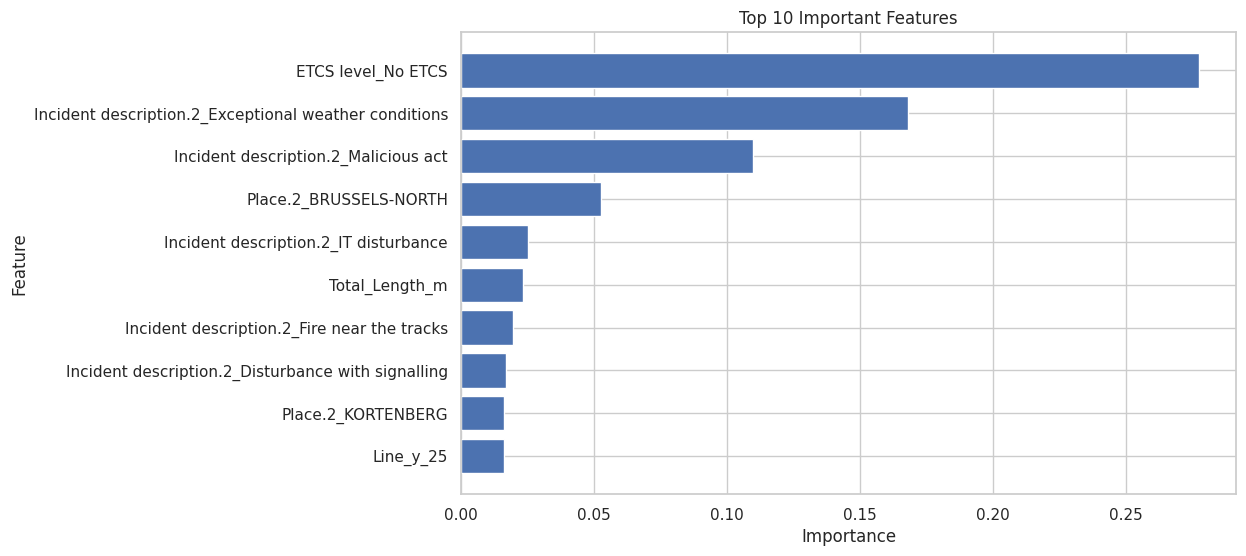

In [78]:
# Create a column transformer for both numeric and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values for numeric features
            ('scaler', StandardScaler())  # Standardize 'Total_Length_m'
        ]), ['Total_Length_m']),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values for categorical features
            ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))  # Encode categorical variables
        ]), ['Line_y', 'Place.2', 'Incident description.2', 'ETCS level'])  # Categorical variables
    ])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline with the preprocessor and model
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                            ('model', RandomForestRegressor(n_estimators=200, random_state=42))])  # Include the model in the pipeline

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Make predictions on the test data
y_pred = pipeline.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.2f}')
print(f'R-squared: {r2:.2f}')

# Feature Importance
# Since we are using a pipeline, we need to extract the model after fitting
model = pipeline.named_steps['model']
encoder = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']

# Get feature names from the OneHotEncoder and numeric features
encoded_features = encoder.get_feature_names_out(['Line_y', 'Place.2', 'Incident description.2', 'ETCS level'])

# Combine numeric and encoded feature names
numeric_features = ['Total_Length_m']
all_feature_names = numeric_features + list(encoded_features)

# Feature importance from the model
importances = model.feature_importances_

# Create a DataFrame for feature importance and sort by importance
feature_importance_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# Display the top 10 important features
print(feature_importance_df.head(10))

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'][:10], feature_importance_df['Importance'][:10])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Important Features')
plt.gca().invert_yaxis()  # Invert y-axis to show top feature at the top
plt.show()